In [1]:
import os
import shutil

if os.path.exists('./avocado_price'):
  shutil.rmtree('./avocado_price')
!git clone https://github.com/volsky/avocado_price.git
!pip install catboost

Cloning into 'avocado_price'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 10]

In [3]:
raw_df = pd.read_csv("./avocado_price/avocado.csv", index_col="Unnamed: 0", parse_dates=['Date'])
raw_df['Month'] = raw_df.Date.dt.month
raw_df['Quarter'] = ((raw_df['Month'] - 1) / 3).astype(int)

In [4]:
raw_df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Month,Quarter
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,12,3
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,12,3
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,12,3
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,12,3
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,11,3


In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 0 to 11
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18249 non-null  datetime64[ns]
 1   AveragePrice  18249 non-null  float64       
 2   Total Volume  18249 non-null  float64       
 3   4046          18249 non-null  float64       
 4   4225          18249 non-null  float64       
 5   4770          18249 non-null  float64       
 6   Total Bags    18249 non-null  float64       
 7   Small Bags    18249 non-null  float64       
 8   Large Bags    18249 non-null  float64       
 9   XLarge Bags   18249 non-null  float64       
 10  type          18249 non-null  object        
 11  year          18249 non-null  int64         
 12  region        18249 non-null  object        
 13  Month         18249 non-null  int64         
 14  Quarter       18249 non-null  int64         
dtypes: datetime64[ns](1), float64(9), int64

In [6]:
raw_df.describe()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year,Month,Quarter
count,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000,18249.000000,18249.000000
mean,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899,6.177215,1.402323
std,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938,3.534130,1.147834
min,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000,1.000000,0.000000
25%,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000,3.000000,0.000000
50%,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000,6.000000,1.000000
75%,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000,9.000000,2.000000
max,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000,12.000000,3.000000


In [7]:
raw_df.type.value_counts()

conventional    9126
organic         9123
Name: type, dtype: int64

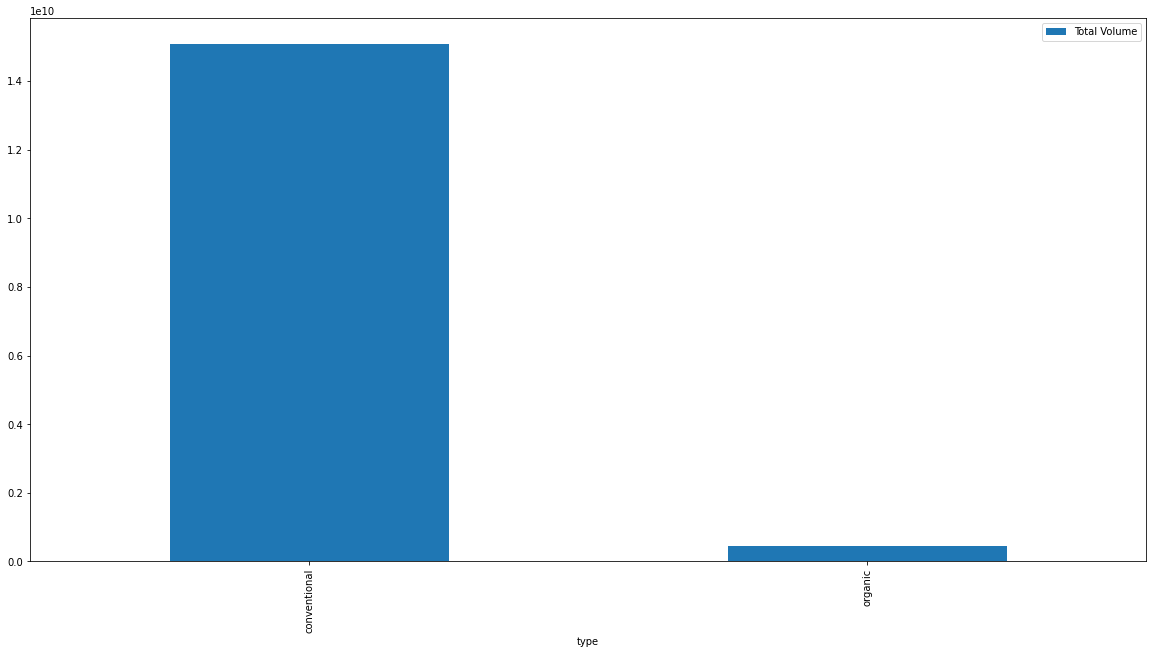

In [8]:
raw_df[['Total Volume', 'type']].groupby('type').agg('sum').plot.bar()

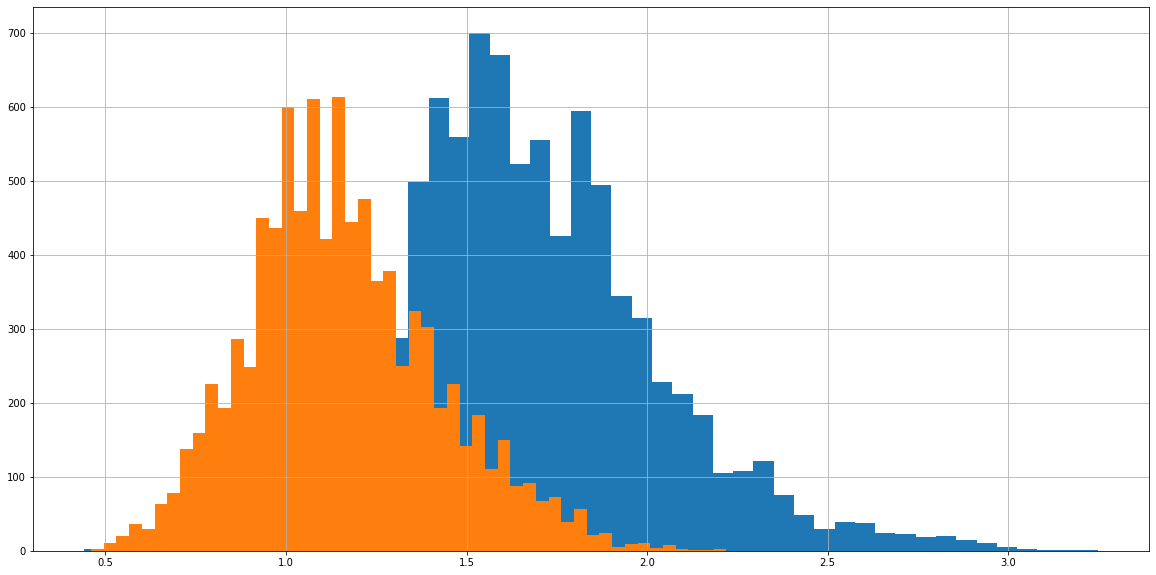

In [9]:
raw_df[raw_df.type == 'organic'].AveragePrice.hist(bins=50)
raw_df[raw_df.type != 'organic'].AveragePrice.hist(bins=50)

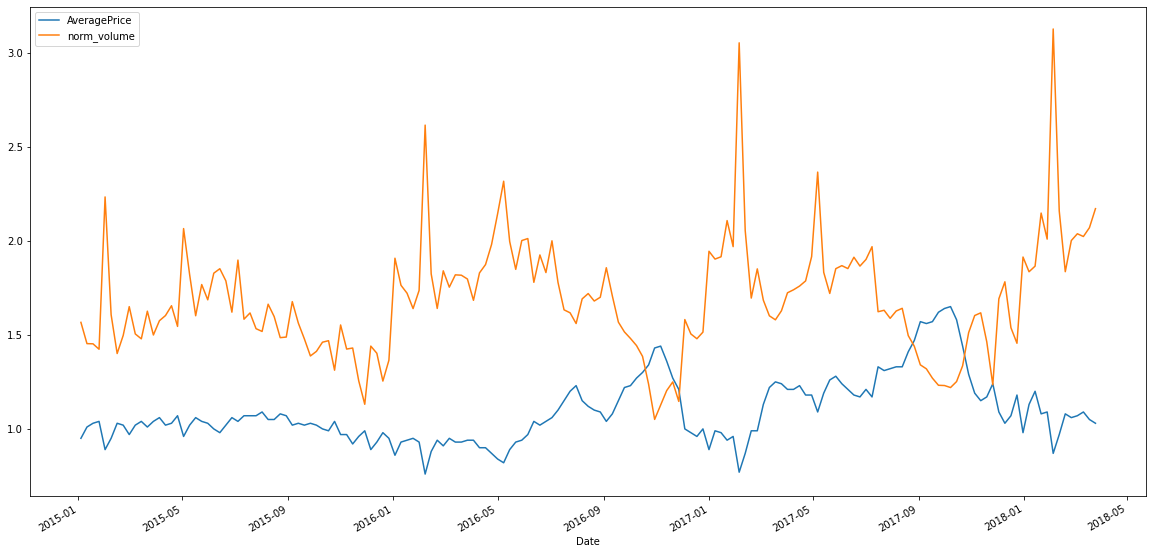

In [10]:
import numpy as np

raw_df['norm_volume'] = raw_df['Total Volume'] / 20_000_000
# raw_df['norm_demand'] = raw_df['Total Bags'] / 50_000
raw_df[
       (raw_df.region == 'TotalUS') &
      #  (raw_df.year == 2015) &
       (raw_df.type == 'conventional')
][['Date',
    'AveragePrice',
    'norm_volume',
    # 'Total Volume',
   ]].plot(x="Date")

In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor
from fbprophet import Prophet
import itertools
from datetime import timedelta


def get_relevant_data(region, avocado_type):
  data_with_labels = raw_df[
    (raw_df.region == region) &
    (raw_df.type == avocado_type)
  ].drop(
      columns=['type', 'region']
  ).sort_values(by='Date').copy()

  return data_with_labels


def split_data(data_with_labels):
  data_with_labels.sort_values(by='Date', inplace=True)
  yFinal = data_with_labels.pop('AveragePrice').to_numpy()
  tscv = TimeSeriesSplit(n_splits=2)
  train_index, test_index = list(tscv.split(data_with_labels))[1]
  return (
      data_with_labels.iloc[train_index],
      data_with_labels.iloc[test_index],
      yFinal[train_index],
      yFinal[test_index]
  )


def train_and_eval_cat_boost(x_trainFinal, x_testFinal, y_trainFinal, y_testFinal):
  model = CatBoostRegressor(logging_level='Silent', subsample=0.6)
  grid = {'iterations': [50, 100, 150, 200, 250],
          'learning_rate': [0.1, 0.3, 0.5, 1],
          'depth': [5, 6, 7, 8, 9, 10],
          'l2_leaf_reg': [1, 3, 5, 7, 9],
          'rsm': [0.8, 0.9, 1]}

  randomized_search_result = model.randomized_search(grid,
                                                    X=x_trainFinal,
                                                    y=y_trainFinal,
                                                    search_by_train_test_split=False)
  model = CatBoostRegressor(**randomized_search_result['params'])
  model.set_params(subsample=0.6)
  model.fit(X=x_trainFinal, y=y_trainFinal)
  mse = np.sqrt(mean_squared_error(np.log(1 + y_testFinal), np.log(1 + model.predict(x_testFinal))))
  return model, mse


def train_and_eval_prophet(x_trainFinal, x_testFinal, y_trainFinal, y_testFinal):
  prophet = Prophet()
  prophet.fit(pd.DataFrame({'ds': x_trainFinal.Date, 'y': y_trainFinal}))
  future = prophet.make_future_dataframe(
      freq='W', include_history=False, periods=len(y_testFinal))
  forecast = prophet.predict(future)
  p_mse = np.sqrt(mean_squared_error(np.log(1 + y_testFinal), np.log(1 + forecast.yhat)))
  return prophet, p_mse
  

def eval_models(raw_df):
  model_results = []
  for atype, aregion in itertools.product(raw_df.type.unique(), raw_df.region.unique()):
    print(f'start training model for {atype} in {aregion}')
    partial_data = raw_df.loc[
        (raw_df.region == aregion) &
        (raw_df.type == atype)
      ].drop(columns=['type', 'region'])
    x_trainFinal, x_testFinal, y_trainFinal, y_testFinal = split_data(partial_data)
    model, mse = train_and_eval_cat_boost(x_trainFinal, x_testFinal, y_trainFinal, y_testFinal)
    prophet_model, p_mse = train_and_eval_prophet(x_trainFinal, x_testFinal, y_trainFinal, y_testFinal)
    print(f'trained model for {atype} in {aregion}, prophet mse={p_mse}, cat boost mse={mse}')
    model_results.append({
        'type': atype,
        'region': aregion,
        'cat_boost': model, 
        'cat_boost_mse': mse,
        'prophet': prophet_model,
        'prophet_mse': p_mse
    })
  return model_results

res = eval_models(raw_df)

start training model for conventional in Albany
0:	loss: 0.1637482	best: 0.1637482 (0)	total: 805ms	remaining: 7.25s
1:	loss: 0.2064977	best: 0.1637482 (0)	total: 1.51s	remaining: 6.05s
2:	loss: 0.1988930	best: 0.1637482 (0)	total: 3.28s	remaining: 7.66s
3:	loss: 0.2366670	best: 0.1637482 (0)	total: 4.7s	remaining: 7.06s
4:	loss: 0.2624095	best: 0.1637482 (0)	total: 9.41s	remaining: 9.41s
5:	loss: 0.2594690	best: 0.1637482 (0)	total: 14s	remaining: 9.32s
6:	loss: 0.2333103	best: 0.1637482 (0)	total: 14.3s	remaining: 6.13s
7:	loss: 0.3006443	best: 0.1637482 (0)	total: 15.7s	remaining: 3.92s
8:	loss: 0.2018590	best: 0.1637482 (0)	total: 16.5s	remaining: 1.83s
9:	loss: 0.2224998	best: 0.1637482 (0)	total: 18.6s	remaining: 0us
0:	learn: 0.1650636	total: 853us	remaining: 170ms
1:	learn: 0.1561990	total: 2.48ms	remaining: 246ms
2:	learn: 0.1434236	total: 3.56ms	remaining: 234ms
3:	learn: 0.1369156	total: 4.56ms	remaining: 224ms
4:	learn: 0.1296372	total: 5.54ms	remaining: 216ms
5:	learn: 0.1

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


trained model for conventional in Albany, prophet mse=0.11771316569810783, cat boost mse=0.09615042794496108
start training model for conventional in Atlanta
0:	loss: 0.0826615	best: 0.0826615 (0)	total: 663ms	remaining: 5.97s
1:	loss: 0.1563170	best: 0.0826615 (0)	total: 1.37s	remaining: 5.5s
2:	loss: 0.1250682	best: 0.0826615 (0)	total: 3.21s	remaining: 7.49s
3:	loss: 0.1550929	best: 0.0826615 (0)	total: 4.5s	remaining: 6.76s
4:	loss: 0.1696520	best: 0.0826615 (0)	total: 9.18s	remaining: 9.18s
5:	loss: 0.1607052	best: 0.0826615 (0)	total: 13.9s	remaining: 9.25s
6:	loss: 0.1311833	best: 0.0826615 (0)	total: 14.2s	remaining: 6.08s
7:	loss: 0.1370067	best: 0.0826615 (0)	total: 15.6s	remaining: 3.89s
8:	loss: 0.1197281	best: 0.0826615 (0)	total: 16.4s	remaining: 1.82s
9:	loss: 0.1393104	best: 0.0826615 (0)	total: 18.6s	remaining: 0us
0:	learn: 0.1139471	total: 938us	remaining: 187ms
1:	learn: 0.1010488	total: 1.81ms	remaining: 179ms
2:	learn: 0.0889994	total: 2.96ms	remaining: 195ms
3:	l

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


168:	learn: 0.0032029	total: 179ms	remaining: 32.9ms
169:	learn: 0.0031533	total: 181ms	remaining: 32ms
170:	learn: 0.0031067	total: 188ms	remaining: 31.8ms
171:	learn: 0.0030752	total: 189ms	remaining: 30.7ms
172:	learn: 0.0030395	total: 191ms	remaining: 29.9ms
173:	learn: 0.0029703	total: 193ms	remaining: 28.8ms
174:	learn: 0.0029266	total: 193ms	remaining: 27.6ms
175:	learn: 0.0028609	total: 195ms	remaining: 26.5ms
176:	learn: 0.0028085	total: 196ms	remaining: 25.4ms
177:	learn: 0.0027789	total: 197ms	remaining: 24.3ms
178:	learn: 0.0027220	total: 198ms	remaining: 23.2ms
179:	learn: 0.0026661	total: 199ms	remaining: 22.1ms
180:	learn: 0.0026375	total: 200ms	remaining: 21ms
181:	learn: 0.0026222	total: 201ms	remaining: 19.9ms
182:	learn: 0.0025952	total: 202ms	remaining: 18.7ms
183:	learn: 0.0025465	total: 203ms	remaining: 17.6ms
184:	learn: 0.0025162	total: 204ms	remaining: 16.5ms
185:	learn: 0.0024808	total: 205ms	remaining: 15.4ms
186:	learn: 0.0024677	total: 206ms	remaining: 14.3

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


169:	learn: 0.0037585	total: 185ms	remaining: 32.7ms
170:	learn: 0.0037496	total: 187ms	remaining: 31.7ms
171:	learn: 0.0037130	total: 189ms	remaining: 30.8ms
172:	learn: 0.0036558	total: 191ms	remaining: 29.8ms
173:	learn: 0.0036463	total: 193ms	remaining: 28.8ms
174:	learn: 0.0036210	total: 195ms	remaining: 27.8ms
175:	learn: 0.0035778	total: 197ms	remaining: 26.8ms
176:	learn: 0.0035132	total: 198ms	remaining: 25.7ms
177:	learn: 0.0034685	total: 200ms	remaining: 24.7ms
178:	learn: 0.0034379	total: 201ms	remaining: 23.6ms
179:	learn: 0.0034218	total: 202ms	remaining: 22.4ms
180:	learn: 0.0033646	total: 203ms	remaining: 21.3ms
181:	learn: 0.0033083	total: 204ms	remaining: 20.2ms
182:	learn: 0.0032707	total: 205ms	remaining: 19ms
183:	learn: 0.0032203	total: 206ms	remaining: 17.9ms
184:	learn: 0.0031987	total: 207ms	remaining: 16.8ms
185:	learn: 0.0031671	total: 208ms	remaining: 15.7ms
186:	learn: 0.0031345	total: 209ms	remaining: 14.5ms
187:	learn: 0.0030876	total: 210ms	remaining: 13

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


163:	learn: 0.0035315	total: 176ms	remaining: 38.5ms
164:	learn: 0.0034597	total: 177ms	remaining: 37.6ms
165:	learn: 0.0034240	total: 179ms	remaining: 36.6ms
166:	learn: 0.0033539	total: 181ms	remaining: 35.7ms
167:	learn: 0.0032684	total: 183ms	remaining: 34.9ms
168:	learn: 0.0032150	total: 187ms	remaining: 34.4ms
169:	learn: 0.0031649	total: 189ms	remaining: 33.3ms
170:	learn: 0.0031240	total: 190ms	remaining: 32.1ms
171:	learn: 0.0031128	total: 190ms	remaining: 31ms
172:	learn: 0.0030573	total: 191ms	remaining: 29.8ms
173:	learn: 0.0030368	total: 192ms	remaining: 28.7ms
174:	learn: 0.0030261	total: 193ms	remaining: 27.5ms
175:	learn: 0.0029756	total: 194ms	remaining: 26.4ms
176:	learn: 0.0029551	total: 195ms	remaining: 25.3ms
177:	learn: 0.0029183	total: 196ms	remaining: 24.2ms
178:	learn: 0.0028889	total: 196ms	remaining: 23ms
179:	learn: 0.0028786	total: 197ms	remaining: 21.9ms
180:	learn: 0.0028556	total: 198ms	remaining: 20.8ms
181:	learn: 0.0028352	total: 199ms	remaining: 19.7

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


174:	learn: 0.0044022	total: 181ms	remaining: 25.8ms
175:	learn: 0.0043910	total: 183ms	remaining: 24.9ms
176:	learn: 0.0043324	total: 184ms	remaining: 23.9ms
177:	learn: 0.0043035	total: 185ms	remaining: 22.9ms
178:	learn: 0.0042929	total: 186ms	remaining: 21.9ms
179:	learn: 0.0042222	total: 188ms	remaining: 20.8ms
180:	learn: 0.0041732	total: 189ms	remaining: 19.8ms
181:	learn: 0.0041322	total: 190ms	remaining: 18.7ms
182:	learn: 0.0041211	total: 191ms	remaining: 17.7ms
183:	learn: 0.0040829	total: 192ms	remaining: 16.7ms
184:	learn: 0.0040536	total: 193ms	remaining: 15.6ms
185:	learn: 0.0039820	total: 194ms	remaining: 14.6ms
186:	learn: 0.0039437	total: 195ms	remaining: 13.5ms
187:	learn: 0.0038889	total: 195ms	remaining: 12.5ms
188:	learn: 0.0038258	total: 197ms	remaining: 11.4ms
189:	learn: 0.0037873	total: 198ms	remaining: 10.4ms
190:	learn: 0.0037688	total: 198ms	remaining: 9.35ms
191:	learn: 0.0037051	total: 199ms	remaining: 8.3ms
192:	learn: 0.0036815	total: 200ms	remaining: 7

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


164:	learn: 0.0059501	total: 179ms	remaining: 37.9ms
165:	learn: 0.0058068	total: 180ms	remaining: 36.9ms
166:	learn: 0.0057455	total: 181ms	remaining: 35.8ms
167:	learn: 0.0056900	total: 182ms	remaining: 34.7ms
168:	learn: 0.0056456	total: 184ms	remaining: 33.7ms
169:	learn: 0.0055937	total: 191ms	remaining: 33.7ms
170:	learn: 0.0055219	total: 192ms	remaining: 32.5ms
171:	learn: 0.0054781	total: 192ms	remaining: 31.3ms
172:	learn: 0.0053837	total: 193ms	remaining: 30.1ms
173:	learn: 0.0052735	total: 194ms	remaining: 29ms
174:	learn: 0.0051885	total: 195ms	remaining: 27.9ms
175:	learn: 0.0050890	total: 196ms	remaining: 26.8ms
176:	learn: 0.0050384	total: 197ms	remaining: 25.6ms
177:	learn: 0.0049432	total: 198ms	remaining: 24.5ms
178:	learn: 0.0049258	total: 199ms	remaining: 23.4ms
179:	learn: 0.0048400	total: 200ms	remaining: 22.3ms
180:	learn: 0.0047576	total: 202ms	remaining: 21.2ms
181:	learn: 0.0047306	total: 203ms	remaining: 20ms
182:	learn: 0.0046485	total: 203ms	remaining: 18.9

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


trained model for conventional in California, prophet mse=0.09522913809061907, cat boost mse=0.10941981679693293
start training model for conventional in Charlotte
0:	loss: 0.1162615	best: 0.1162615 (0)	total: 646ms	remaining: 5.81s
1:	loss: 0.2180065	best: 0.1162615 (0)	total: 1.36s	remaining: 5.43s
2:	loss: 0.1421336	best: 0.1162615 (0)	total: 3.18s	remaining: 7.41s
3:	loss: 0.1708217	best: 0.1162615 (0)	total: 4.44s	remaining: 6.66s
4:	loss: 0.1855829	best: 0.1162615 (0)	total: 9.03s	remaining: 9.03s
5:	loss: 0.1880492	best: 0.1162615 (0)	total: 13.5s	remaining: 9.01s
6:	loss: 0.1383062	best: 0.1162615 (0)	total: 13.8s	remaining: 5.92s
7:	loss: 0.1986145	best: 0.1162615 (0)	total: 15.1s	remaining: 3.78s
8:	loss: 0.1440252	best: 0.1162615 (0)	total: 15.9s	remaining: 1.76s
9:	loss: 0.1668753	best: 0.1162615 (0)	total: 18s	remaining: 0us
0:	learn: 0.1489407	total: 945us	remaining: 188ms
1:	learn: 0.1357035	total: 2.43ms	remaining: 241ms
2:	learn: 0.1201455	total: 3.5ms	remaining: 230ms

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


171:	learn: 0.0024593	total: 178ms	remaining: 28.9ms
172:	learn: 0.0024337	total: 184ms	remaining: 28.7ms
173:	learn: 0.0024176	total: 185ms	remaining: 27.7ms
174:	learn: 0.0024057	total: 187ms	remaining: 26.7ms
175:	learn: 0.0023790	total: 188ms	remaining: 25.6ms
176:	learn: 0.0023717	total: 189ms	remaining: 24.5ms
177:	learn: 0.0023275	total: 190ms	remaining: 23.5ms
178:	learn: 0.0022953	total: 191ms	remaining: 22.4ms
179:	learn: 0.0022403	total: 192ms	remaining: 21.3ms
180:	learn: 0.0022006	total: 193ms	remaining: 20.2ms
181:	learn: 0.0021594	total: 194ms	remaining: 19.2ms
182:	learn: 0.0021456	total: 195ms	remaining: 18.1ms
183:	learn: 0.0021089	total: 196ms	remaining: 17ms
184:	learn: 0.0020879	total: 197ms	remaining: 16ms
185:	learn: 0.0020498	total: 198ms	remaining: 14.9ms
186:	learn: 0.0020113	total: 199ms	remaining: 13.8ms
187:	learn: 0.0019763	total: 200ms	remaining: 12.8ms
188:	learn: 0.0019545	total: 201ms	remaining: 11.7ms
189:	learn: 0.0019232	total: 202ms	remaining: 10.6

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


162:	learn: 0.0069489	total: 181ms	remaining: 41.1ms
163:	learn: 0.0068497	total: 183ms	remaining: 40.1ms
164:	learn: 0.0067281	total: 184ms	remaining: 39ms
165:	learn: 0.0067030	total: 185ms	remaining: 37.9ms
166:	learn: 0.0066097	total: 186ms	remaining: 36.8ms
167:	learn: 0.0065906	total: 187ms	remaining: 35.7ms
168:	learn: 0.0064698	total: 188ms	remaining: 34.6ms
169:	learn: 0.0063964	total: 190ms	remaining: 33.4ms
170:	learn: 0.0063212	total: 191ms	remaining: 32.3ms
171:	learn: 0.0062171	total: 192ms	remaining: 31.2ms
172:	learn: 0.0061442	total: 193ms	remaining: 30.1ms
173:	learn: 0.0060971	total: 194ms	remaining: 29ms
174:	learn: 0.0060051	total: 195ms	remaining: 27.8ms
175:	learn: 0.0059176	total: 196ms	remaining: 26.7ms
176:	learn: 0.0058067	total: 197ms	remaining: 25.6ms
177:	learn: 0.0057137	total: 198ms	remaining: 24.5ms
178:	learn: 0.0056198	total: 199ms	remaining: 23.4ms
179:	learn: 0.0055949	total: 200ms	remaining: 22.3ms
180:	learn: 0.0055654	total: 202ms	remaining: 21.2

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


trained model for conventional in CincinnatiDayton, prophet mse=0.18515363053284326, cat boost mse=0.15122084969141297
start training model for conventional in Columbus
0:	loss: 0.1111892	best: 0.1111892 (0)	total: 663ms	remaining: 5.97s
1:	loss: 0.1698128	best: 0.1111892 (0)	total: 1.39s	remaining: 5.58s
2:	loss: 0.1266829	best: 0.1111892 (0)	total: 3.24s	remaining: 7.56s
3:	loss: 0.1588901	best: 0.1111892 (0)	total: 4.68s	remaining: 7.02s
4:	loss: 0.2327567	best: 0.1111892 (0)	total: 9.75s	remaining: 9.75s
5:	loss: 0.2011984	best: 0.1111892 (0)	total: 14.5s	remaining: 9.66s
6:	loss: 0.1353527	best: 0.1111892 (0)	total: 14.8s	remaining: 6.35s
7:	loss: 0.1696498	best: 0.1111892 (0)	total: 16.2s	remaining: 4.05s
8:	loss: 0.1429948	best: 0.1111892 (0)	total: 17s	remaining: 1.89s
9:	loss: 0.1585745	best: 0.1111892 (0)	total: 19.2s	remaining: 0us
0:	learn: 0.1104924	total: 908us	remaining: 181ms
1:	learn: 0.1007800	total: 2.35ms	remaining: 233ms
2:	learn: 0.0919551	total: 3.45ms	remaining:

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


160:	learn: 0.0032787	total: 177ms	remaining: 43ms
161:	learn: 0.0032639	total: 180ms	remaining: 42.3ms
162:	learn: 0.0031896	total: 182ms	remaining: 41.2ms
163:	learn: 0.0031634	total: 183ms	remaining: 40.1ms
164:	learn: 0.0031197	total: 184ms	remaining: 39ms
165:	learn: 0.0030519	total: 185ms	remaining: 38ms
166:	learn: 0.0029961	total: 190ms	remaining: 37.6ms
167:	learn: 0.0029385	total: 192ms	remaining: 36.5ms
168:	learn: 0.0029067	total: 193ms	remaining: 35.4ms
169:	learn: 0.0028617	total: 194ms	remaining: 34.2ms
170:	learn: 0.0028133	total: 195ms	remaining: 33.1ms
171:	learn: 0.0027827	total: 196ms	remaining: 31.9ms
172:	learn: 0.0027540	total: 197ms	remaining: 30.8ms
173:	learn: 0.0027038	total: 198ms	remaining: 29.6ms
174:	learn: 0.0026676	total: 199ms	remaining: 28.4ms
175:	learn: 0.0026477	total: 200ms	remaining: 27.3ms
176:	learn: 0.0026116	total: 201ms	remaining: 26.1ms
177:	learn: 0.0025725	total: 202ms	remaining: 25ms
178:	learn: 0.0025008	total: 203ms	remaining: 23.8ms
1

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


166:	learn: 0.0039148	total: 186ms	remaining: 36.8ms
167:	learn: 0.0038747	total: 188ms	remaining: 35.9ms
168:	learn: 0.0038235	total: 190ms	remaining: 34.8ms
169:	learn: 0.0037644	total: 192ms	remaining: 33.9ms
170:	learn: 0.0036797	total: 193ms	remaining: 32.8ms
171:	learn: 0.0036461	total: 195ms	remaining: 31.8ms
172:	learn: 0.0036029	total: 196ms	remaining: 30.7ms
173:	learn: 0.0035826	total: 197ms	remaining: 29.5ms
174:	learn: 0.0035509	total: 198ms	remaining: 28.3ms
175:	learn: 0.0035126	total: 199ms	remaining: 27.2ms
176:	learn: 0.0034894	total: 201ms	remaining: 26.1ms
177:	learn: 0.0034092	total: 202ms	remaining: 24.9ms
178:	learn: 0.0033549	total: 203ms	remaining: 23.8ms
179:	learn: 0.0033147	total: 204ms	remaining: 22.6ms
180:	learn: 0.0032639	total: 205ms	remaining: 21.5ms
181:	learn: 0.0032146	total: 206ms	remaining: 20.4ms
182:	learn: 0.0031765	total: 207ms	remaining: 19.2ms
183:	learn: 0.0031384	total: 208ms	remaining: 18.1ms
184:	learn: 0.0031312	total: 209ms	remaining: 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


161:	learn: 0.0030729	total: 174ms	remaining: 40.9ms
162:	learn: 0.0030409	total: 176ms	remaining: 39.9ms
163:	learn: 0.0029971	total: 178ms	remaining: 39ms
164:	learn: 0.0029835	total: 182ms	remaining: 38.5ms
165:	learn: 0.0029423	total: 183ms	remaining: 37.4ms
166:	learn: 0.0028941	total: 184ms	remaining: 36.4ms
167:	learn: 0.0028383	total: 185ms	remaining: 35.2ms
168:	learn: 0.0028142	total: 186ms	remaining: 34.1ms
169:	learn: 0.0027802	total: 187ms	remaining: 33ms
170:	learn: 0.0027246	total: 188ms	remaining: 31.8ms
171:	learn: 0.0027080	total: 188ms	remaining: 30.7ms
172:	learn: 0.0026713	total: 189ms	remaining: 29.5ms
173:	learn: 0.0026540	total: 190ms	remaining: 28.4ms
174:	learn: 0.0026116	total: 191ms	remaining: 27.2ms
175:	learn: 0.0025787	total: 192ms	remaining: 26.1ms
176:	learn: 0.0025640	total: 193ms	remaining: 25ms
177:	learn: 0.0025166	total: 194ms	remaining: 24ms
178:	learn: 0.0024981	total: 195ms	remaining: 22.9ms
179:	learn: 0.0024713	total: 196ms	remaining: 21.8ms
1

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


167:	learn: 0.0030922	total: 179ms	remaining: 34ms
168:	learn: 0.0030667	total: 180ms	remaining: 33ms
169:	learn: 0.0030301	total: 181ms	remaining: 32ms
170:	learn: 0.0029827	total: 182ms	remaining: 30.9ms
171:	learn: 0.0029564	total: 184ms	remaining: 29.9ms
172:	learn: 0.0029454	total: 189ms	remaining: 29.6ms
173:	learn: 0.0029093	total: 194ms	remaining: 29ms
174:	learn: 0.0028488	total: 195ms	remaining: 27.9ms
175:	learn: 0.0027642	total: 198ms	remaining: 27.1ms
176:	learn: 0.0027369	total: 201ms	remaining: 26.2ms
177:	learn: 0.0026942	total: 203ms	remaining: 25.1ms
178:	learn: 0.0026517	total: 204ms	remaining: 23.9ms
179:	learn: 0.0026400	total: 205ms	remaining: 22.8ms
180:	learn: 0.0026028	total: 206ms	remaining: 21.6ms
181:	learn: 0.0025669	total: 207ms	remaining: 20.5ms
182:	learn: 0.0025256	total: 208ms	remaining: 19.3ms
183:	learn: 0.0025163	total: 209ms	remaining: 18.2ms
184:	learn: 0.0024559	total: 210ms	remaining: 17ms
185:	learn: 0.0024341	total: 211ms	remaining: 15.9ms
186

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


162:	learn: 0.0043578	total: 186ms	remaining: 42.3ms
163:	learn: 0.0043033	total: 188ms	remaining: 41.2ms
164:	learn: 0.0042418	total: 189ms	remaining: 40.1ms
165:	learn: 0.0042168	total: 190ms	remaining: 38.9ms
166:	learn: 0.0041884	total: 191ms	remaining: 37.7ms
167:	learn: 0.0041357	total: 192ms	remaining: 36.6ms
168:	learn: 0.0040465	total: 193ms	remaining: 35.4ms
169:	learn: 0.0039896	total: 194ms	remaining: 34.3ms
170:	learn: 0.0039523	total: 195ms	remaining: 33.1ms
171:	learn: 0.0039208	total: 196ms	remaining: 32ms
172:	learn: 0.0038822	total: 198ms	remaining: 30.8ms
173:	learn: 0.0038682	total: 199ms	remaining: 29.7ms
174:	learn: 0.0038156	total: 200ms	remaining: 28.5ms
175:	learn: 0.0037284	total: 201ms	remaining: 27.3ms
176:	learn: 0.0036820	total: 202ms	remaining: 26.2ms
177:	learn: 0.0035976	total: 202ms	remaining: 25ms
178:	learn: 0.0035533	total: 204ms	remaining: 23.9ms
179:	learn: 0.0034942	total: 205ms	remaining: 22.8ms
180:	learn: 0.0034612	total: 206ms	remaining: 21.6

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


161:	learn: 0.0045822	total: 179ms	remaining: 42ms
162:	learn: 0.0045006	total: 181ms	remaining: 41ms
163:	learn: 0.0044456	total: 185ms	remaining: 40.6ms
164:	learn: 0.0043763	total: 186ms	remaining: 39.5ms
165:	learn: 0.0043087	total: 187ms	remaining: 38.4ms
166:	learn: 0.0042434	total: 188ms	remaining: 37.2ms
167:	learn: 0.0041776	total: 193ms	remaining: 36.7ms
168:	learn: 0.0041468	total: 194ms	remaining: 35.6ms
169:	learn: 0.0041264	total: 196ms	remaining: 34.6ms
170:	learn: 0.0040757	total: 199ms	remaining: 33.7ms
171:	learn: 0.0040194	total: 199ms	remaining: 32.5ms
172:	learn: 0.0039851	total: 201ms	remaining: 31.3ms
173:	learn: 0.0039197	total: 202ms	remaining: 30.1ms
174:	learn: 0.0038623	total: 203ms	remaining: 28.9ms
175:	learn: 0.0038065	total: 204ms	remaining: 27.8ms
176:	learn: 0.0037356	total: 205ms	remaining: 26.6ms
177:	learn: 0.0036788	total: 206ms	remaining: 25.4ms
178:	learn: 0.0036092	total: 207ms	remaining: 24.3ms
179:	learn: 0.0035858	total: 208ms	remaining: 23.1

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


171:	learn: 0.0036519	total: 172ms	remaining: 28ms
172:	learn: 0.0036136	total: 179ms	remaining: 27.9ms
173:	learn: 0.0035258	total: 180ms	remaining: 26.9ms
174:	learn: 0.0034804	total: 181ms	remaining: 25.9ms
175:	learn: 0.0034290	total: 183ms	remaining: 24.9ms
176:	learn: 0.0033842	total: 184ms	remaining: 23.9ms
177:	learn: 0.0033553	total: 185ms	remaining: 22.9ms
178:	learn: 0.0033145	total: 186ms	remaining: 21.8ms
179:	learn: 0.0032391	total: 187ms	remaining: 20.7ms
180:	learn: 0.0032058	total: 188ms	remaining: 19.7ms
181:	learn: 0.0031916	total: 189ms	remaining: 18.7ms
182:	learn: 0.0031200	total: 190ms	remaining: 17.6ms
183:	learn: 0.0030971	total: 191ms	remaining: 16.6ms
184:	learn: 0.0030664	total: 192ms	remaining: 15.5ms
185:	learn: 0.0030217	total: 193ms	remaining: 14.5ms
186:	learn: 0.0029911	total: 194ms	remaining: 13.5ms
187:	learn: 0.0029529	total: 195ms	remaining: 12.4ms
188:	learn: 0.0029380	total: 196ms	remaining: 11.4ms
189:	learn: 0.0028944	total: 197ms	remaining: 10

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


167:	learn: 0.0060178	total: 183ms	remaining: 34.8ms
168:	learn: 0.0059854	total: 184ms	remaining: 33.8ms
169:	learn: 0.0058705	total: 186ms	remaining: 32.8ms
170:	learn: 0.0057634	total: 188ms	remaining: 31.8ms
171:	learn: 0.0056968	total: 189ms	remaining: 30.7ms
172:	learn: 0.0056240	total: 190ms	remaining: 29.6ms
173:	learn: 0.0055759	total: 191ms	remaining: 28.5ms
174:	learn: 0.0054617	total: 193ms	remaining: 27.5ms
175:	learn: 0.0053496	total: 194ms	remaining: 26.4ms
176:	learn: 0.0052927	total: 195ms	remaining: 25.3ms
177:	learn: 0.0052584	total: 196ms	remaining: 24.2ms
178:	learn: 0.0051898	total: 197ms	remaining: 23.1ms
179:	learn: 0.0051075	total: 198ms	remaining: 22ms
180:	learn: 0.0050612	total: 200ms	remaining: 21ms
181:	learn: 0.0049715	total: 201ms	remaining: 19.9ms
182:	learn: 0.0049616	total: 202ms	remaining: 18.8ms
183:	learn: 0.0048665	total: 203ms	remaining: 17.7ms
184:	learn: 0.0048310	total: 204ms	remaining: 16.6ms
185:	learn: 0.0048054	total: 205ms	remaining: 15.5

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


trained model for conventional in Houston, prophet mse=0.09016432159805822, cat boost mse=0.10954355822044663
start training model for conventional in Indianapolis
0:	loss: 0.1084087	best: 0.1084087 (0)	total: 691ms	remaining: 6.22s
1:	loss: 0.1487808	best: 0.1084087 (0)	total: 1.41s	remaining: 5.65s
2:	loss: 0.1212221	best: 0.1084087 (0)	total: 3.28s	remaining: 7.66s
3:	loss: 0.1557635	best: 0.1084087 (0)	total: 4.63s	remaining: 6.95s
4:	loss: 0.1701970	best: 0.1084087 (0)	total: 9.45s	remaining: 9.45s
5:	loss: 0.1796052	best: 0.1084087 (0)	total: 14.1s	remaining: 9.42s
6:	loss: 0.1061995	best: 0.1061995 (6)	total: 14.5s	remaining: 6.19s
7:	loss: 0.1670420	best: 0.1061995 (6)	total: 15.8s	remaining: 3.94s
8:	loss: 0.1172623	best: 0.1061995 (6)	total: 16.5s	remaining: 1.84s
9:	loss: 0.1323539	best: 0.1061995 (6)	total: 18.7s	remaining: 0us
0:	learn: 0.1132949	total: 1.87ms	remaining: 91.7ms
1:	learn: 0.0903542	total: 3.74ms	remaining: 89.7ms
2:	learn: 0.0734548	total: 5.54ms	remaining:

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


31:	learn: 0.0107719	total: 65ms	remaining: 36.6ms
32:	learn: 0.0102627	total: 68.3ms	remaining: 35.2ms
33:	learn: 0.0098339	total: 70ms	remaining: 32.9ms
34:	learn: 0.0095010	total: 71.9ms	remaining: 30.8ms
35:	learn: 0.0091609	total: 73.6ms	remaining: 28.6ms
36:	learn: 0.0086596	total: 75.3ms	remaining: 26.4ms
37:	learn: 0.0080711	total: 77ms	remaining: 24.3ms
38:	learn: 0.0076853	total: 78.6ms	remaining: 22.2ms
39:	learn: 0.0071967	total: 80.3ms	remaining: 20.1ms
40:	learn: 0.0067580	total: 82ms	remaining: 18ms
41:	learn: 0.0064067	total: 83.6ms	remaining: 15.9ms
42:	learn: 0.0059813	total: 85.2ms	remaining: 13.9ms
43:	learn: 0.0057934	total: 86.9ms	remaining: 11.8ms
44:	learn: 0.0055886	total: 88.5ms	remaining: 9.83ms
45:	learn: 0.0053451	total: 90.1ms	remaining: 7.84ms
46:	learn: 0.0049706	total: 91.8ms	remaining: 5.86ms
47:	learn: 0.0047885	total: 93.4ms	remaining: 3.89ms
48:	learn: 0.0044679	total: 95.1ms	remaining: 1.94ms
49:	learn: 0.0044173	total: 96.7ms	remaining: 0us
traine

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


174:	learn: 0.0048611	total: 181ms	remaining: 25.8ms
175:	learn: 0.0047661	total: 182ms	remaining: 24.9ms
176:	learn: 0.0047573	total: 184ms	remaining: 23.9ms
177:	learn: 0.0046922	total: 185ms	remaining: 22.9ms
178:	learn: 0.0046440	total: 189ms	remaining: 22.2ms
179:	learn: 0.0045624	total: 191ms	remaining: 21.3ms
180:	learn: 0.0045330	total: 193ms	remaining: 20.3ms
181:	learn: 0.0044884	total: 194ms	remaining: 19.2ms
182:	learn: 0.0044642	total: 195ms	remaining: 18.2ms
183:	learn: 0.0044529	total: 197ms	remaining: 17.1ms
184:	learn: 0.0044235	total: 198ms	remaining: 16ms
185:	learn: 0.0043966	total: 199ms	remaining: 15ms
186:	learn: 0.0043356	total: 200ms	remaining: 13.9ms
187:	learn: 0.0042770	total: 201ms	remaining: 12.8ms
188:	learn: 0.0042279	total: 202ms	remaining: 11.8ms
189:	learn: 0.0041907	total: 203ms	remaining: 10.7ms
190:	learn: 0.0041120	total: 204ms	remaining: 9.62ms
191:	learn: 0.0040448	total: 205ms	remaining: 8.55ms
192:	learn: 0.0040266	total: 206ms	remaining: 7.48

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


177:	learn: 0.0042208	total: 185ms	remaining: 22.8ms
178:	learn: 0.0041950	total: 186ms	remaining: 21.8ms
179:	learn: 0.0041544	total: 188ms	remaining: 20.9ms
180:	learn: 0.0041420	total: 190ms	remaining: 20ms
181:	learn: 0.0040922	total: 193ms	remaining: 19ms
182:	learn: 0.0040376	total: 194ms	remaining: 18.1ms
183:	learn: 0.0039769	total: 195ms	remaining: 17ms
184:	learn: 0.0039548	total: 196ms	remaining: 15.9ms
185:	learn: 0.0038320	total: 197ms	remaining: 14.9ms
186:	learn: 0.0037513	total: 198ms	remaining: 13.8ms
187:	learn: 0.0037066	total: 199ms	remaining: 12.7ms
188:	learn: 0.0036614	total: 200ms	remaining: 11.7ms
189:	learn: 0.0036042	total: 201ms	remaining: 10.6ms
190:	learn: 0.0035713	total: 202ms	remaining: 9.53ms
191:	learn: 0.0035524	total: 203ms	remaining: 8.47ms
192:	learn: 0.0034910	total: 204ms	remaining: 7.41ms
193:	learn: 0.0034165	total: 205ms	remaining: 6.35ms
194:	learn: 0.0033778	total: 206ms	remaining: 5.29ms
195:	learn: 0.0033222	total: 207ms	remaining: 4.23ms

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


165:	learn: 0.0035397	total: 183ms	remaining: 37.5ms
166:	learn: 0.0035096	total: 185ms	remaining: 36.5ms
167:	learn: 0.0034578	total: 188ms	remaining: 35.8ms
168:	learn: 0.0034467	total: 189ms	remaining: 34.8ms
169:	learn: 0.0034296	total: 190ms	remaining: 33.6ms
170:	learn: 0.0033758	total: 191ms	remaining: 32.4ms
171:	learn: 0.0033492	total: 192ms	remaining: 31.2ms
172:	learn: 0.0032893	total: 193ms	remaining: 30.1ms
173:	learn: 0.0032436	total: 193ms	remaining: 28.9ms
174:	learn: 0.0032242	total: 194ms	remaining: 27.7ms
175:	learn: 0.0031485	total: 195ms	remaining: 26.6ms
176:	learn: 0.0031320	total: 196ms	remaining: 25.5ms
177:	learn: 0.0031260	total: 197ms	remaining: 24.3ms
178:	learn: 0.0030733	total: 198ms	remaining: 23.2ms
179:	learn: 0.0030172	total: 199ms	remaining: 22.1ms
180:	learn: 0.0029823	total: 200ms	remaining: 21ms
181:	learn: 0.0029266	total: 201ms	remaining: 19.9ms
182:	learn: 0.0029007	total: 202ms	remaining: 18.8ms
183:	learn: 0.0028524	total: 203ms	remaining: 17

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


168:	learn: 0.0050555	total: 178ms	remaining: 32.7ms
169:	learn: 0.0050167	total: 179ms	remaining: 31.7ms
170:	learn: 0.0050016	total: 181ms	remaining: 30.6ms
171:	learn: 0.0048774	total: 183ms	remaining: 29.8ms
172:	learn: 0.0048548	total: 188ms	remaining: 29.4ms
173:	learn: 0.0048329	total: 191ms	remaining: 28.5ms
174:	learn: 0.0048208	total: 200ms	remaining: 28.5ms
175:	learn: 0.0047253	total: 201ms	remaining: 27.4ms
176:	learn: 0.0046765	total: 202ms	remaining: 26.2ms
177:	learn: 0.0046440	total: 203ms	remaining: 25.1ms
178:	learn: 0.0045545	total: 204ms	remaining: 23.9ms
179:	learn: 0.0045095	total: 205ms	remaining: 22.8ms
180:	learn: 0.0044415	total: 206ms	remaining: 21.6ms
181:	learn: 0.0044317	total: 207ms	remaining: 20.5ms
182:	learn: 0.0044074	total: 208ms	remaining: 19.3ms
183:	learn: 0.0043379	total: 209ms	remaining: 18.2ms
184:	learn: 0.0041986	total: 210ms	remaining: 17.1ms
185:	learn: 0.0041331	total: 212ms	remaining: 15.9ms
186:	learn: 0.0040810	total: 213ms	remaining: 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


trained model for conventional in MiamiFtLauderdale, prophet mse=0.12033939887439588, cat boost mse=0.12932122032493465
start training model for conventional in Midsouth
0:	loss: 0.1035097	best: 0.1035097 (0)	total: 684ms	remaining: 6.16s
1:	loss: 0.1909749	best: 0.1035097 (0)	total: 1.41s	remaining: 5.62s
2:	loss: 0.1321457	best: 0.1035097 (0)	total: 3.21s	remaining: 7.49s
3:	loss: 0.1549442	best: 0.1035097 (0)	total: 4.5s	remaining: 6.75s
4:	loss: 0.2211912	best: 0.1035097 (0)	total: 9.38s	remaining: 9.38s
5:	loss: 0.2149784	best: 0.1035097 (0)	total: 14.1s	remaining: 9.39s
6:	loss: 0.1740366	best: 0.1035097 (0)	total: 14.4s	remaining: 6.17s
7:	loss: 0.1813220	best: 0.1035097 (0)	total: 15.8s	remaining: 3.94s
8:	loss: 0.1444744	best: 0.1035097 (0)	total: 16.6s	remaining: 1.84s
9:	loss: 0.1618816	best: 0.1035097 (0)	total: 18.8s	remaining: 0us
0:	learn: 0.1089342	total: 975us	remaining: 194ms
1:	learn: 0.1001073	total: 1.88ms	remaining: 186ms
2:	learn: 0.0896858	total: 2.7ms	remaining

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


171:	learn: 0.0020124	total: 175ms	remaining: 28.5ms
172:	learn: 0.0019948	total: 183ms	remaining: 28.6ms
173:	learn: 0.0019761	total: 186ms	remaining: 27.8ms
174:	learn: 0.0019415	total: 188ms	remaining: 26.9ms
175:	learn: 0.0019270	total: 189ms	remaining: 25.8ms
176:	learn: 0.0019175	total: 190ms	remaining: 24.7ms
177:	learn: 0.0018900	total: 191ms	remaining: 23.7ms
178:	learn: 0.0018546	total: 193ms	remaining: 22.6ms
179:	learn: 0.0018365	total: 196ms	remaining: 21.8ms
180:	learn: 0.0018258	total: 198ms	remaining: 20.7ms
181:	learn: 0.0017866	total: 199ms	remaining: 19.7ms
182:	learn: 0.0017782	total: 200ms	remaining: 18.6ms
183:	learn: 0.0017488	total: 201ms	remaining: 17.5ms
184:	learn: 0.0017366	total: 202ms	remaining: 16.4ms
185:	learn: 0.0017060	total: 203ms	remaining: 15.3ms
186:	learn: 0.0016692	total: 205ms	remaining: 14.2ms
187:	learn: 0.0016475	total: 206ms	remaining: 13.1ms
188:	learn: 0.0016394	total: 207ms	remaining: 12ms
189:	learn: 0.0016042	total: 208ms	remaining: 11

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


240:	learn: 0.0002591	total: 565ms	remaining: 21.1ms
241:	learn: 0.0002545	total: 569ms	remaining: 18.8ms
242:	learn: 0.0002490	total: 570ms	remaining: 16.4ms
243:	learn: 0.0002437	total: 572ms	remaining: 14.1ms
244:	learn: 0.0002409	total: 574ms	remaining: 11.7ms
245:	learn: 0.0002390	total: 576ms	remaining: 9.37ms
246:	learn: 0.0002366	total: 578ms	remaining: 7.02ms
247:	learn: 0.0002352	total: 582ms	remaining: 4.69ms
248:	learn: 0.0002304	total: 586ms	remaining: 2.35ms
249:	learn: 0.0002272	total: 589ms	remaining: 0us
trained model for conventional in Nashville, prophet mse=0.10189115347331018, cat boost mse=0.11152954165405714
start training model for conventional in NewOrleansMobile
0:	loss: 0.1081972	best: 0.1081972 (0)	total: 662ms	remaining: 5.95s
1:	loss: 0.2375047	best: 0.1081972 (0)	total: 1.42s	remaining: 5.67s
2:	loss: 0.1243179	best: 0.1081972 (0)	total: 3.22s	remaining: 7.51s
3:	loss: 0.2027014	best: 0.1081972 (0)	total: 4.72s	remaining: 7.08s
4:	loss: 0.2063503	best: 0.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


178:	learn: 0.0039876	total: 166ms	remaining: 19.4ms
179:	learn: 0.0039160	total: 167ms	remaining: 18.6ms
180:	learn: 0.0038816	total: 169ms	remaining: 17.7ms
181:	learn: 0.0038443	total: 170ms	remaining: 16.8ms
182:	learn: 0.0038047	total: 172ms	remaining: 16ms
183:	learn: 0.0037475	total: 173ms	remaining: 15.1ms
184:	learn: 0.0037027	total: 175ms	remaining: 14.2ms
185:	learn: 0.0036349	total: 177ms	remaining: 13.3ms
186:	learn: 0.0036166	total: 178ms	remaining: 12.4ms
187:	learn: 0.0035658	total: 179ms	remaining: 11.4ms
188:	learn: 0.0035306	total: 180ms	remaining: 10.5ms
189:	learn: 0.0035048	total: 181ms	remaining: 9.52ms
190:	learn: 0.0034463	total: 182ms	remaining: 8.57ms
191:	learn: 0.0034263	total: 183ms	remaining: 7.62ms
192:	learn: 0.0033876	total: 184ms	remaining: 6.68ms
193:	learn: 0.0033107	total: 186ms	remaining: 5.74ms
194:	learn: 0.0032778	total: 190ms	remaining: 4.86ms
195:	learn: 0.0032471	total: 191ms	remaining: 3.9ms
196:	learn: 0.0031975	total: 195ms	remaining: 2.9

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


trained model for conventional in NewYork, prophet mse=0.14834183676135862, cat boost mse=0.08116091494348332
start training model for conventional in Northeast
0:	loss: 0.1061383	best: 0.1061383 (0)	total: 686ms	remaining: 6.17s
1:	loss: 0.2247815	best: 0.1061383 (0)	total: 1.45s	remaining: 5.81s
2:	loss: 0.1640056	best: 0.1061383 (0)	total: 3.22s	remaining: 7.52s
3:	loss: 0.2242814	best: 0.1061383 (0)	total: 4.57s	remaining: 6.85s
4:	loss: 0.2626080	best: 0.1061383 (0)	total: 9.08s	remaining: 9.08s
5:	loss: 0.2371524	best: 0.1061383 (0)	total: 13.8s	remaining: 9.2s
6:	loss: 0.1585533	best: 0.1061383 (0)	total: 14.1s	remaining: 6.05s
7:	loss: 0.1890265	best: 0.1061383 (0)	total: 15.4s	remaining: 3.85s
8:	loss: 0.1568386	best: 0.1061383 (0)	total: 16.2s	remaining: 1.8s
9:	loss: 0.1934210	best: 0.1061383 (0)	total: 18.4s	remaining: 0us
0:	learn: 0.1438492	total: 943us	remaining: 188ms
1:	learn: 0.1305908	total: 1.83ms	remaining: 181ms
2:	learn: 0.1175411	total: 2.71ms	remaining: 178ms
3

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


161:	learn: 0.0057560	total: 177ms	remaining: 41.4ms
162:	learn: 0.0056681	total: 179ms	remaining: 40.6ms
163:	learn: 0.0056122	total: 184ms	remaining: 40.3ms
164:	learn: 0.0055173	total: 185ms	remaining: 39.3ms
165:	learn: 0.0054158	total: 188ms	remaining: 38.5ms
166:	learn: 0.0053398	total: 190ms	remaining: 37.6ms
167:	learn: 0.0052723	total: 192ms	remaining: 36.5ms
168:	learn: 0.0051378	total: 193ms	remaining: 35.4ms
169:	learn: 0.0051245	total: 194ms	remaining: 34.2ms
170:	learn: 0.0050676	total: 195ms	remaining: 33.1ms
171:	learn: 0.0049762	total: 196ms	remaining: 31.9ms
172:	learn: 0.0049268	total: 197ms	remaining: 30.8ms
173:	learn: 0.0049058	total: 198ms	remaining: 29.6ms
174:	learn: 0.0048661	total: 199ms	remaining: 28.5ms
175:	learn: 0.0048031	total: 200ms	remaining: 27.3ms
176:	learn: 0.0047429	total: 201ms	remaining: 26.2ms
177:	learn: 0.0046782	total: 202ms	remaining: 25ms
178:	learn: 0.0046122	total: 203ms	remaining: 23.9ms
179:	learn: 0.0045987	total: 205ms	remaining: 22

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


179:	learn: 0.0044279	total: 178ms	remaining: 19.8ms
180:	learn: 0.0043920	total: 179ms	remaining: 18.8ms
181:	learn: 0.0043244	total: 181ms	remaining: 17.9ms
182:	learn: 0.0043126	total: 182ms	remaining: 16.9ms
183:	learn: 0.0042740	total: 183ms	remaining: 15.9ms
184:	learn: 0.0042100	total: 184ms	remaining: 14.9ms
185:	learn: 0.0041490	total: 185ms	remaining: 13.9ms
186:	learn: 0.0041037	total: 189ms	remaining: 13.1ms
187:	learn: 0.0040488	total: 190ms	remaining: 12.1ms
188:	learn: 0.0040111	total: 191ms	remaining: 11.1ms
189:	learn: 0.0039690	total: 194ms	remaining: 10.2ms
190:	learn: 0.0039121	total: 195ms	remaining: 9.17ms
191:	learn: 0.0038766	total: 196ms	remaining: 8.16ms
192:	learn: 0.0038665	total: 203ms	remaining: 7.37ms
193:	learn: 0.0038151	total: 205ms	remaining: 6.33ms
194:	learn: 0.0037790	total: 207ms	remaining: 5.32ms
195:	learn: 0.0037443	total: 210ms	remaining: 4.28ms
196:	learn: 0.0036997	total: 211ms	remaining: 3.21ms
197:	learn: 0.0036785	total: 212ms	remaining: 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


174:	learn: 0.0038860	total: 180ms	remaining: 25.7ms
175:	learn: 0.0037959	total: 181ms	remaining: 24.7ms
176:	learn: 0.0037689	total: 183ms	remaining: 23.7ms
177:	learn: 0.0037459	total: 185ms	remaining: 22.9ms
178:	learn: 0.0036557	total: 187ms	remaining: 21.9ms
179:	learn: 0.0036294	total: 188ms	remaining: 20.9ms
180:	learn: 0.0036043	total: 189ms	remaining: 19.8ms
181:	learn: 0.0035238	total: 190ms	remaining: 18.8ms
182:	learn: 0.0035054	total: 191ms	remaining: 17.8ms
183:	learn: 0.0034372	total: 192ms	remaining: 16.7ms
184:	learn: 0.0034093	total: 193ms	remaining: 15.7ms
185:	learn: 0.0033625	total: 194ms	remaining: 14.6ms
186:	learn: 0.0033160	total: 195ms	remaining: 13.6ms
187:	learn: 0.0032949	total: 196ms	remaining: 12.5ms
188:	learn: 0.0032626	total: 197ms	remaining: 11.5ms
189:	learn: 0.0032100	total: 198ms	remaining: 10.4ms
190:	learn: 0.0031869	total: 199ms	remaining: 9.38ms
191:	learn: 0.0031605	total: 200ms	remaining: 8.33ms
192:	learn: 0.0031298	total: 201ms	remaining: 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


157:	learn: 0.0059934	total: 167ms	remaining: 44.4ms
158:	learn: 0.0059308	total: 176ms	remaining: 45.3ms
159:	learn: 0.0059039	total: 177ms	remaining: 44.3ms
160:	learn: 0.0058722	total: 179ms	remaining: 43.4ms
161:	learn: 0.0056989	total: 182ms	remaining: 42.6ms
162:	learn: 0.0055823	total: 184ms	remaining: 41.8ms
163:	learn: 0.0054488	total: 187ms	remaining: 41.1ms
164:	learn: 0.0054039	total: 188ms	remaining: 39.9ms
165:	learn: 0.0053446	total: 189ms	remaining: 38.7ms
166:	learn: 0.0052399	total: 190ms	remaining: 37.5ms
167:	learn: 0.0051715	total: 191ms	remaining: 36.4ms
168:	learn: 0.0050586	total: 192ms	remaining: 35.2ms
169:	learn: 0.0050067	total: 192ms	remaining: 34ms
170:	learn: 0.0049138	total: 193ms	remaining: 32.8ms
171:	learn: 0.0048433	total: 195ms	remaining: 31.7ms
172:	learn: 0.0048231	total: 196ms	remaining: 30.6ms
173:	learn: 0.0047817	total: 197ms	remaining: 29.5ms
174:	learn: 0.0047011	total: 198ms	remaining: 28.3ms
175:	learn: 0.0046143	total: 199ms	remaining: 27

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


171:	learn: 0.0034957	total: 189ms	remaining: 30.8ms
172:	learn: 0.0034529	total: 191ms	remaining: 29.8ms
173:	learn: 0.0034288	total: 192ms	remaining: 28.7ms
174:	learn: 0.0034114	total: 193ms	remaining: 27.6ms
175:	learn: 0.0033850	total: 194ms	remaining: 26.4ms
176:	learn: 0.0033201	total: 195ms	remaining: 25.3ms
177:	learn: 0.0033132	total: 196ms	remaining: 24.2ms
178:	learn: 0.0032450	total: 198ms	remaining: 23.2ms
179:	learn: 0.0032090	total: 199ms	remaining: 22.2ms
180:	learn: 0.0031737	total: 200ms	remaining: 21ms
181:	learn: 0.0031290	total: 201ms	remaining: 19.9ms
182:	learn: 0.0030890	total: 202ms	remaining: 18.8ms
183:	learn: 0.0030492	total: 203ms	remaining: 17.7ms
184:	learn: 0.0030054	total: 204ms	remaining: 16.6ms
185:	learn: 0.0029489	total: 206ms	remaining: 15.5ms
186:	learn: 0.0029254	total: 206ms	remaining: 14.4ms
187:	learn: 0.0029059	total: 207ms	remaining: 13.2ms
188:	learn: 0.0028956	total: 208ms	remaining: 12.1ms
189:	learn: 0.0028533	total: 209ms	remaining: 11

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


trained model for conventional in Pittsburgh, prophet mse=0.07820167981180294, cat boost mse=0.06360293792707306
start training model for conventional in Plains
0:	loss: 0.1013323	best: 0.1013323 (0)	total: 661ms	remaining: 5.95s
1:	loss: 0.2530711	best: 0.1013323 (0)	total: 1.43s	remaining: 5.71s
2:	loss: 0.1330870	best: 0.1013323 (0)	total: 3.35s	remaining: 7.82s
3:	loss: 0.1635335	best: 0.1013323 (0)	total: 4.7s	remaining: 7.04s
4:	loss: 0.2303059	best: 0.1013323 (0)	total: 9.52s	remaining: 9.52s
5:	loss: 0.2157035	best: 0.1013323 (0)	total: 14.7s	remaining: 9.77s
6:	loss: 0.1603155	best: 0.1013323 (0)	total: 15s	remaining: 6.42s
7:	loss: 0.2092135	best: 0.1013323 (0)	total: 16.3s	remaining: 4.08s
8:	loss: 0.1583085	best: 0.1013323 (0)	total: 17.1s	remaining: 1.9s
9:	loss: 0.1559949	best: 0.1013323 (0)	total: 19.2s	remaining: 0us
0:	learn: 0.1310510	total: 901us	remaining: 179ms
1:	learn: 0.1161378	total: 2.31ms	remaining: 229ms
2:	learn: 0.1042578	total: 3.41ms	remaining: 224ms
3:	

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


trained model for conventional in Plains, prophet mse=0.08716079139289233, cat boost mse=0.11770167947141938
start training model for conventional in Portland
0:	loss: 0.1068699	best: 0.1068699 (0)	total: 666ms	remaining: 5.99s
1:	loss: 0.2093559	best: 0.1068699 (0)	total: 1.4s	remaining: 5.59s
2:	loss: 0.1351741	best: 0.1068699 (0)	total: 3.24s	remaining: 7.57s
3:	loss: 0.1644385	best: 0.1068699 (0)	total: 4.87s	remaining: 7.31s
4:	loss: 0.2204123	best: 0.1068699 (0)	total: 9.56s	remaining: 9.56s
5:	loss: 0.2122839	best: 0.1068699 (0)	total: 14.3s	remaining: 9.55s
6:	loss: 0.1465138	best: 0.1068699 (0)	total: 14.7s	remaining: 6.29s
7:	loss: 0.1919833	best: 0.1068699 (0)	total: 16s	remaining: 4s
8:	loss: 0.1339702	best: 0.1068699 (0)	total: 16.8s	remaining: 1.87s
9:	loss: 0.1483907	best: 0.1068699 (0)	total: 19.1s	remaining: 0us
0:	learn: 0.1388278	total: 940us	remaining: 187ms
1:	learn: 0.1275520	total: 1.83ms	remaining: 181ms
2:	learn: 0.1155902	total: 2.66ms	remaining: 175ms
3:	lear

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


trained model for conventional in Portland, prophet mse=0.1688721809846642, cat boost mse=0.141752723110638
start training model for conventional in RaleighGreensboro
0:	loss: 0.1076224	best: 0.1076224 (0)	total: 658ms	remaining: 5.92s
1:	loss: 0.1961814	best: 0.1076224 (0)	total: 1.39s	remaining: 5.57s
2:	loss: 0.1374872	best: 0.1076224 (0)	total: 3.16s	remaining: 7.37s
3:	loss: 0.1513382	best: 0.1076224 (0)	total: 4.46s	remaining: 6.69s
4:	loss: 0.2195153	best: 0.1076224 (0)	total: 8.99s	remaining: 8.99s
5:	loss: 0.2097189	best: 0.1076224 (0)	total: 13.6s	remaining: 9.03s
6:	loss: 0.1613663	best: 0.1076224 (0)	total: 13.9s	remaining: 5.94s
7:	loss: 0.2290776	best: 0.1076224 (0)	total: 15.2s	remaining: 3.79s
8:	loss: 0.1346496	best: 0.1076224 (0)	total: 15.9s	remaining: 1.77s
9:	loss: 0.1551958	best: 0.1076224 (0)	total: 18s	remaining: 0us
0:	learn: 0.1179261	total: 875us	remaining: 174ms
1:	learn: 0.1068995	total: 2.65ms	remaining: 263ms
2:	learn: 0.0976538	total: 3.76ms	remaining: 2

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


168:	learn: 0.0028439	total: 178ms	remaining: 32.6ms
169:	learn: 0.0028245	total: 180ms	remaining: 31.7ms
170:	learn: 0.0028133	total: 181ms	remaining: 30.6ms
171:	learn: 0.0027448	total: 182ms	remaining: 29.6ms
172:	learn: 0.0027048	total: 183ms	remaining: 28.6ms
173:	learn: 0.0026600	total: 184ms	remaining: 27.6ms
174:	learn: 0.0026379	total: 190ms	remaining: 27.2ms
175:	learn: 0.0025910	total: 191ms	remaining: 26.1ms
176:	learn: 0.0025457	total: 193ms	remaining: 25ms
177:	learn: 0.0025195	total: 198ms	remaining: 24.4ms
178:	learn: 0.0024561	total: 199ms	remaining: 23.3ms
179:	learn: 0.0024131	total: 200ms	remaining: 22.2ms
180:	learn: 0.0023757	total: 200ms	remaining: 21ms
181:	learn: 0.0023425	total: 201ms	remaining: 19.9ms
182:	learn: 0.0022975	total: 202ms	remaining: 18.8ms
183:	learn: 0.0022524	total: 203ms	remaining: 17.6ms
184:	learn: 0.0022067	total: 204ms	remaining: 16.5ms
185:	learn: 0.0021885	total: 205ms	remaining: 15.4ms
186:	learn: 0.0021546	total: 205ms	remaining: 14.3

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


trained model for conventional in RichmondNorfolk, prophet mse=0.09667678978990368, cat boost mse=0.08056565892830028
start training model for conventional in Roanoke
0:	loss: 0.1043080	best: 0.1043080 (0)	total: 668ms	remaining: 6.01s
1:	loss: 0.1825526	best: 0.1043080 (0)	total: 1.38s	remaining: 5.5s
2:	loss: 0.1179085	best: 0.1043080 (0)	total: 3.22s	remaining: 7.52s
3:	loss: 0.1425261	best: 0.1043080 (0)	total: 4.47s	remaining: 6.7s
4:	loss: 0.1890258	best: 0.1043080 (0)	total: 8.92s	remaining: 8.92s
5:	loss: 0.1891989	best: 0.1043080 (0)	total: 13.6s	remaining: 9.1s
6:	loss: 0.1400172	best: 0.1043080 (0)	total: 14s	remaining: 5.99s
7:	loss: 0.2116057	best: 0.1043080 (0)	total: 15.3s	remaining: 3.82s
8:	loss: 0.1287024	best: 0.1043080 (0)	total: 16.1s	remaining: 1.78s
9:	loss: 0.1414258	best: 0.1043080 (0)	total: 18.1s	remaining: 0us
0:	learn: 0.0900321	total: 870us	remaining: 173ms
1:	learn: 0.0846848	total: 1.85ms	remaining: 183ms
2:	learn: 0.0756085	total: 2.66ms	remaining: 175m

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


172:	learn: 0.0021709	total: 185ms	remaining: 28.9ms
173:	learn: 0.0021510	total: 188ms	remaining: 28.1ms
174:	learn: 0.0021212	total: 189ms	remaining: 27ms
175:	learn: 0.0021084	total: 190ms	remaining: 25.9ms
176:	learn: 0.0020884	total: 191ms	remaining: 24.8ms
177:	learn: 0.0020788	total: 192ms	remaining: 23.7ms
178:	learn: 0.0020703	total: 193ms	remaining: 22.6ms
179:	learn: 0.0019990	total: 194ms	remaining: 21.6ms
180:	learn: 0.0019732	total: 195ms	remaining: 20.5ms
181:	learn: 0.0019368	total: 196ms	remaining: 19.4ms
182:	learn: 0.0019178	total: 197ms	remaining: 18.3ms
183:	learn: 0.0018924	total: 198ms	remaining: 17.2ms
184:	learn: 0.0018731	total: 199ms	remaining: 16.1ms
185:	learn: 0.0018475	total: 200ms	remaining: 15.1ms
186:	learn: 0.0018224	total: 201ms	remaining: 14ms
187:	learn: 0.0018084	total: 202ms	remaining: 12.9ms
188:	learn: 0.0017956	total: 203ms	remaining: 11.8ms
189:	learn: 0.0017658	total: 204ms	remaining: 10.8ms
190:	learn: 0.0017341	total: 205ms	remaining: 9.67

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


173:	learn: 0.0030081	total: 174ms	remaining: 26ms
174:	learn: 0.0029571	total: 180ms	remaining: 25.7ms
175:	learn: 0.0029182	total: 181ms	remaining: 24.7ms
176:	learn: 0.0028636	total: 184ms	remaining: 23.9ms
177:	learn: 0.0028320	total: 185ms	remaining: 22.9ms
178:	learn: 0.0027980	total: 186ms	remaining: 21.8ms
179:	learn: 0.0027337	total: 187ms	remaining: 20.8ms
180:	learn: 0.0026816	total: 189ms	remaining: 19.8ms
181:	learn: 0.0026536	total: 192ms	remaining: 19ms
182:	learn: 0.0026288	total: 193ms	remaining: 17.9ms
183:	learn: 0.0025953	total: 194ms	remaining: 16.9ms
184:	learn: 0.0025585	total: 195ms	remaining: 15.8ms
185:	learn: 0.0025282	total: 196ms	remaining: 14.8ms
186:	learn: 0.0025152	total: 197ms	remaining: 13.7ms
187:	learn: 0.0024870	total: 198ms	remaining: 12.6ms
188:	learn: 0.0024548	total: 199ms	remaining: 11.6ms
189:	learn: 0.0024042	total: 200ms	remaining: 10.5ms
190:	learn: 0.0023592	total: 201ms	remaining: 9.47ms
191:	learn: 0.0023045	total: 202ms	remaining: 8.42

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


155:	learn: 0.0045951	total: 174ms	remaining: 49.2ms
156:	learn: 0.0045286	total: 176ms	remaining: 48.2ms
157:	learn: 0.0044576	total: 178ms	remaining: 47.2ms
158:	learn: 0.0044087	total: 179ms	remaining: 46.2ms
159:	learn: 0.0043917	total: 181ms	remaining: 45.3ms
160:	learn: 0.0043530	total: 185ms	remaining: 44.8ms
161:	learn: 0.0043058	total: 186ms	remaining: 43.6ms
162:	learn: 0.0042758	total: 187ms	remaining: 42.4ms
163:	learn: 0.0042400	total: 188ms	remaining: 41.3ms
164:	learn: 0.0041665	total: 189ms	remaining: 40.1ms
165:	learn: 0.0041455	total: 190ms	remaining: 38.9ms
166:	learn: 0.0040760	total: 191ms	remaining: 37.8ms
167:	learn: 0.0040270	total: 192ms	remaining: 36.6ms
168:	learn: 0.0039238	total: 193ms	remaining: 35.4ms
169:	learn: 0.0038768	total: 194ms	remaining: 34.3ms
170:	learn: 0.0037991	total: 195ms	remaining: 33.1ms
171:	learn: 0.0037805	total: 196ms	remaining: 32ms
172:	learn: 0.0037262	total: 197ms	remaining: 30.8ms
173:	learn: 0.0036738	total: 198ms	remaining: 29

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


163:	learn: 0.0054313	total: 177ms	remaining: 38.8ms
164:	learn: 0.0052966	total: 178ms	remaining: 37.8ms
165:	learn: 0.0051900	total: 180ms	remaining: 36.8ms
166:	learn: 0.0051552	total: 181ms	remaining: 35.8ms
167:	learn: 0.0051058	total: 182ms	remaining: 34.7ms
168:	learn: 0.0049938	total: 183ms	remaining: 33.6ms
169:	learn: 0.0049083	total: 188ms	remaining: 33.1ms
170:	learn: 0.0047539	total: 189ms	remaining: 32ms
171:	learn: 0.0046527	total: 191ms	remaining: 31.1ms
172:	learn: 0.0045876	total: 192ms	remaining: 30ms
173:	learn: 0.0045176	total: 194ms	remaining: 29ms
174:	learn: 0.0044486	total: 198ms	remaining: 28.3ms
175:	learn: 0.0043858	total: 200ms	remaining: 27.2ms
176:	learn: 0.0043127	total: 201ms	remaining: 26.1ms
177:	learn: 0.0042135	total: 202ms	remaining: 25ms
178:	learn: 0.0041189	total: 203ms	remaining: 23.8ms
179:	learn: 0.0040504	total: 204ms	remaining: 22.7ms
180:	learn: 0.0040058	total: 205ms	remaining: 21.5ms
181:	learn: 0.0039540	total: 206ms	remaining: 20.4ms
1

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


trained model for conventional in Seattle, prophet mse=0.18249327690307368, cat boost mse=0.16940557133342182
start training model for conventional in SouthCarolina
0:	loss: 0.0989582	best: 0.0989582 (0)	total: 722ms	remaining: 6.5s
1:	loss: 0.1299502	best: 0.0989582 (0)	total: 1.49s	remaining: 5.97s
2:	loss: 0.1096249	best: 0.0989582 (0)	total: 3.48s	remaining: 8.12s
3:	loss: 0.1309712	best: 0.0989582 (0)	total: 4.96s	remaining: 7.45s
4:	loss: 0.1773300	best: 0.0989582 (0)	total: 10.2s	remaining: 10.2s
5:	loss: 0.1675243	best: 0.0989582 (0)	total: 15.3s	remaining: 10.2s
6:	loss: 0.1722282	best: 0.0989582 (0)	total: 15.7s	remaining: 6.73s
7:	loss: 0.1938662	best: 0.0989582 (0)	total: 17.1s	remaining: 4.26s
8:	loss: 0.1406671	best: 0.0989582 (0)	total: 17.9s	remaining: 1.99s
9:	loss: 0.1552694	best: 0.0989582 (0)	total: 20.3s	remaining: 0us
0:	learn: 0.1141173	total: 913us	remaining: 182ms
1:	learn: 0.1062863	total: 2.52ms	remaining: 250ms
2:	learn: 0.0951858	total: 3.71ms	remaining: 24

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


164:	learn: 0.0037578	total: 178ms	remaining: 37.8ms
165:	learn: 0.0037356	total: 180ms	remaining: 36.8ms
166:	learn: 0.0036744	total: 181ms	remaining: 35.8ms
167:	learn: 0.0036343	total: 182ms	remaining: 34.7ms
168:	learn: 0.0035823	total: 184ms	remaining: 33.7ms
169:	learn: 0.0035450	total: 185ms	remaining: 32.6ms
170:	learn: 0.0034928	total: 188ms	remaining: 31.8ms
171:	learn: 0.0034324	total: 190ms	remaining: 30.9ms
172:	learn: 0.0034094	total: 191ms	remaining: 29.8ms
173:	learn: 0.0033837	total: 193ms	remaining: 28.8ms
174:	learn: 0.0033195	total: 194ms	remaining: 27.7ms
175:	learn: 0.0032526	total: 195ms	remaining: 26.6ms
176:	learn: 0.0032165	total: 198ms	remaining: 25.7ms
177:	learn: 0.0031602	total: 199ms	remaining: 24.6ms
178:	learn: 0.0031289	total: 200ms	remaining: 23.5ms
179:	learn: 0.0030860	total: 201ms	remaining: 22.4ms
180:	learn: 0.0030286	total: 202ms	remaining: 21.3ms
181:	learn: 0.0030120	total: 204ms	remaining: 20.1ms
182:	learn: 0.0029405	total: 205ms	remaining: 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


157:	learn: 0.0033041	total: 175ms	remaining: 46.6ms
158:	learn: 0.0032604	total: 178ms	remaining: 45.9ms
159:	learn: 0.0032190	total: 179ms	remaining: 44.8ms
160:	learn: 0.0031826	total: 181ms	remaining: 43.8ms
161:	learn: 0.0031437	total: 182ms	remaining: 42.8ms
162:	learn: 0.0031268	total: 184ms	remaining: 41.7ms
163:	learn: 0.0030702	total: 188ms	remaining: 41.3ms
164:	learn: 0.0030283	total: 189ms	remaining: 40.2ms
165:	learn: 0.0029889	total: 191ms	remaining: 39ms
166:	learn: 0.0029629	total: 192ms	remaining: 37.9ms
167:	learn: 0.0029287	total: 198ms	remaining: 37.7ms
168:	learn: 0.0028808	total: 199ms	remaining: 36.5ms
169:	learn: 0.0028396	total: 200ms	remaining: 35.3ms
170:	learn: 0.0028065	total: 201ms	remaining: 34.1ms
171:	learn: 0.0027507	total: 202ms	remaining: 32.9ms
172:	learn: 0.0027126	total: 203ms	remaining: 31.7ms
173:	learn: 0.0026659	total: 204ms	remaining: 30.5ms
174:	learn: 0.0026534	total: 205ms	remaining: 29.3ms
175:	learn: 0.0026335	total: 206ms	remaining: 28

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


164:	learn: 0.0048391	total: 171ms	remaining: 36.3ms
165:	learn: 0.0047583	total: 173ms	remaining: 35.4ms
166:	learn: 0.0046771	total: 174ms	remaining: 34.4ms
167:	learn: 0.0046280	total: 175ms	remaining: 33.4ms
168:	learn: 0.0045455	total: 177ms	remaining: 32.4ms
169:	learn: 0.0044816	total: 178ms	remaining: 31.4ms
170:	learn: 0.0044499	total: 179ms	remaining: 30.4ms
171:	learn: 0.0043666	total: 181ms	remaining: 29.5ms
172:	learn: 0.0042899	total: 183ms	remaining: 28.5ms
173:	learn: 0.0041883	total: 184ms	remaining: 27.5ms
174:	learn: 0.0041367	total: 185ms	remaining: 26.5ms
175:	learn: 0.0041277	total: 189ms	remaining: 25.8ms
176:	learn: 0.0040886	total: 191ms	remaining: 24.8ms
177:	learn: 0.0040415	total: 192ms	remaining: 23.8ms
178:	learn: 0.0039970	total: 193ms	remaining: 22.7ms
179:	learn: 0.0039769	total: 194ms	remaining: 21.6ms
180:	learn: 0.0039272	total: 195ms	remaining: 20.5ms
181:	learn: 0.0038699	total: 196ms	remaining: 19.4ms
182:	learn: 0.0038319	total: 197ms	remaining: 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


trained model for conventional in Spokane, prophet mse=0.14571333282312465, cat boost mse=0.13436572239522337
start training model for conventional in StLouis
0:	loss: 0.1093925	best: 0.1093925 (0)	total: 670ms	remaining: 6.03s
1:	loss: 0.1923982	best: 0.1093925 (0)	total: 1.4s	remaining: 5.61s
2:	loss: 0.1365255	best: 0.1093925 (0)	total: 3.32s	remaining: 7.74s
3:	loss: 0.1798639	best: 0.1093925 (0)	total: 4.84s	remaining: 7.26s
4:	loss: 0.1781735	best: 0.1093925 (0)	total: 9.67s	remaining: 9.67s
5:	loss: 0.1904104	best: 0.1093925 (0)	total: 14.6s	remaining: 9.71s
6:	loss: 0.1928558	best: 0.1093925 (0)	total: 14.9s	remaining: 6.39s
7:	loss: 0.2286375	best: 0.1093925 (0)	total: 16.2s	remaining: 4.06s
8:	loss: 0.1538843	best: 0.1093925 (0)	total: 17.1s	remaining: 1.89s
9:	loss: 0.1848988	best: 0.1093925 (0)	total: 19.4s	remaining: 0us
0:	learn: 0.1430118	total: 993us	remaining: 198ms
1:	learn: 0.1302109	total: 3.11ms	remaining: 308ms
2:	learn: 0.1177967	total: 4.37ms	remaining: 287ms
3:

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


trained model for conventional in StLouis, prophet mse=0.10075360065424825, cat boost mse=0.1315292057388718
start training model for conventional in Syracuse
0:	loss: 0.1446191	best: 0.1446191 (0)	total: 632ms	remaining: 5.69s
1:	loss: 0.2504742	best: 0.1446191 (0)	total: 1.41s	remaining: 5.65s
2:	loss: 0.1914481	best: 0.1446191 (0)	total: 3.33s	remaining: 7.77s
3:	loss: 0.2683672	best: 0.1446191 (0)	total: 4.86s	remaining: 7.29s
4:	loss: 0.2911726	best: 0.1446191 (0)	total: 9.47s	remaining: 9.47s
5:	loss: 0.2757346	best: 0.1446191 (0)	total: 14.2s	remaining: 9.49s
6:	loss: 0.1956708	best: 0.1446191 (0)	total: 14.6s	remaining: 6.24s
7:	loss: 0.2447111	best: 0.1446191 (0)	total: 15.8s	remaining: 3.95s
8:	loss: 0.1938183	best: 0.1446191 (0)	total: 16.6s	remaining: 1.84s
9:	loss: 0.2249774	best: 0.1446191 (0)	total: 18.7s	remaining: 0us
0:	learn: 0.1055089	total: 914us	remaining: 182ms
1:	learn: 0.0988800	total: 2.32ms	remaining: 230ms
2:	learn: 0.0927506	total: 3.38ms	remaining: 222ms
3

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


trained model for conventional in Syracuse, prophet mse=0.1389998152270824, cat boost mse=0.06283342669758483
start training model for conventional in Tampa
0:	loss: 0.1323918	best: 0.1323918 (0)	total: 711ms	remaining: 6.39s
1:	loss: 0.2048171	best: 0.1323918 (0)	total: 1.42s	remaining: 5.69s
2:	loss: 0.1380937	best: 0.1323918 (0)	total: 3.32s	remaining: 7.74s
3:	loss: 0.1959799	best: 0.1323918 (0)	total: 4.64s	remaining: 6.96s
4:	loss: 0.2355319	best: 0.1323918 (0)	total: 9.82s	remaining: 9.82s
5:	loss: 0.1985812	best: 0.1323918 (0)	total: 15.1s	remaining: 10s
6:	loss: 0.1712852	best: 0.1323918 (0)	total: 15.4s	remaining: 6.59s
7:	loss: 0.2099350	best: 0.1323918 (0)	total: 16.7s	remaining: 4.17s
8:	loss: 0.1527925	best: 0.1323918 (0)	total: 17.5s	remaining: 1.95s
9:	loss: 0.1829780	best: 0.1323918 (0)	total: 19.8s	remaining: 0us
0:	learn: 0.1536059	total: 1.1ms	remaining: 219ms
1:	learn: 0.1373611	total: 1.95ms	remaining: 193ms
2:	learn: 0.1233760	total: 2.79ms	remaining: 183ms
3:	le

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


169:	learn: 0.0037809	total: 174ms	remaining: 30.7ms
170:	learn: 0.0037481	total: 179ms	remaining: 30.3ms
171:	learn: 0.0037088	total: 180ms	remaining: 29.3ms
172:	learn: 0.0036517	total: 182ms	remaining: 28.4ms
173:	learn: 0.0036368	total: 184ms	remaining: 27.6ms
174:	learn: 0.0035837	total: 187ms	remaining: 26.7ms
175:	learn: 0.0035442	total: 190ms	remaining: 25.9ms
176:	learn: 0.0035156	total: 191ms	remaining: 24.9ms
177:	learn: 0.0034833	total: 192ms	remaining: 23.8ms
178:	learn: 0.0034559	total: 193ms	remaining: 22.7ms
179:	learn: 0.0033767	total: 194ms	remaining: 21.6ms
180:	learn: 0.0033098	total: 195ms	remaining: 20.5ms
181:	learn: 0.0032836	total: 196ms	remaining: 19.4ms
182:	learn: 0.0032526	total: 197ms	remaining: 18.3ms
183:	learn: 0.0032225	total: 199ms	remaining: 17.3ms
184:	learn: 0.0032038	total: 200ms	remaining: 16.2ms
185:	learn: 0.0031870	total: 201ms	remaining: 15.1ms
186:	learn: 0.0031583	total: 202ms	remaining: 14ms
187:	learn: 0.0031242	total: 203ms	remaining: 13

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


trained model for conventional in TotalUS, prophet mse=0.06984717361599065, cat boost mse=0.08393906548233283
start training model for conventional in West
0:	loss: 0.0906504	best: 0.0906504 (0)	total: 706ms	remaining: 6.36s
1:	loss: 0.1105838	best: 0.0906504 (0)	total: 1.45s	remaining: 5.81s
2:	loss: 0.1157387	best: 0.0906504 (0)	total: 3.39s	remaining: 7.9s
3:	loss: 0.1190756	best: 0.0906504 (0)	total: 4.87s	remaining: 7.31s
4:	loss: 0.1736276	best: 0.0906504 (0)	total: 9.73s	remaining: 9.73s
5:	loss: 0.1321333	best: 0.0906504 (0)	total: 14.4s	remaining: 9.6s
6:	loss: 0.1188618	best: 0.0906504 (0)	total: 14.7s	remaining: 6.31s
7:	loss: 0.1419453	best: 0.0906504 (0)	total: 16.1s	remaining: 4.01s
8:	loss: 0.1073848	best: 0.0906504 (0)	total: 16.9s	remaining: 1.88s
9:	loss: 0.1129300	best: 0.0906504 (0)	total: 19s	remaining: 0us
0:	learn: 0.0993151	total: 863us	remaining: 172ms
1:	learn: 0.0908250	total: 1.7ms	remaining: 169ms
2:	learn: 0.0818465	total: 2.54ms	remaining: 167ms
3:	learn:

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


trained model for conventional in West, prophet mse=0.08202765030592286, cat boost mse=0.10567927890944699
start training model for conventional in WestTexNewMexico
0:	loss: 0.0895164	best: 0.0895164 (0)	total: 702ms	remaining: 6.32s
1:	loss: 0.0944919	best: 0.0895164 (0)	total: 1.42s	remaining: 5.68s
2:	loss: 0.0998302	best: 0.0895164 (0)	total: 3.28s	remaining: 7.66s
3:	loss: 0.1297857	best: 0.0895164 (0)	total: 4.69s	remaining: 7.04s
4:	loss: 0.1670805	best: 0.0895164 (0)	total: 9.33s	remaining: 9.33s
5:	loss: 0.1482962	best: 0.0895164 (0)	total: 13.9s	remaining: 9.24s
6:	loss: 0.1252925	best: 0.0895164 (0)	total: 14.2s	remaining: 6.08s
7:	loss: 0.1480130	best: 0.0895164 (0)	total: 15.6s	remaining: 3.89s
8:	loss: 0.1256545	best: 0.0895164 (0)	total: 16.4s	remaining: 1.82s
9:	loss: 0.1299931	best: 0.0895164 (0)	total: 18.5s	remaining: 0us
0:	learn: 0.0965814	total: 945us	remaining: 188ms
1:	learn: 0.0897745	total: 2.55ms	remaining: 253ms
2:	learn: 0.0811236	total: 3.61ms	remaining: 2

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


160:	learn: 0.0046598	total: 176ms	remaining: 42.6ms
161:	learn: 0.0046176	total: 177ms	remaining: 41.5ms
162:	learn: 0.0045527	total: 178ms	remaining: 40.5ms
163:	learn: 0.0044952	total: 179ms	remaining: 39.4ms
164:	learn: 0.0044545	total: 181ms	remaining: 38.3ms
165:	learn: 0.0043475	total: 182ms	remaining: 37.3ms
166:	learn: 0.0043062	total: 186ms	remaining: 36.7ms
167:	learn: 0.0042452	total: 187ms	remaining: 35.6ms
168:	learn: 0.0041817	total: 188ms	remaining: 34.5ms
169:	learn: 0.0041631	total: 189ms	remaining: 33.4ms
170:	learn: 0.0041022	total: 194ms	remaining: 32.8ms
171:	learn: 0.0040786	total: 195ms	remaining: 31.8ms
172:	learn: 0.0040616	total: 198ms	remaining: 30.8ms
173:	learn: 0.0039799	total: 200ms	remaining: 29.9ms
174:	learn: 0.0039639	total: 204ms	remaining: 29.2ms
175:	learn: 0.0038779	total: 206ms	remaining: 28.1ms
176:	learn: 0.0038476	total: 207ms	remaining: 26.9ms
177:	learn: 0.0037961	total: 208ms	remaining: 25.7ms
178:	learn: 0.0037473	total: 209ms	remaining: 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


190:	learn: 0.0065845	total: 196ms	remaining: 9.22ms
191:	learn: 0.0065153	total: 197ms	remaining: 8.19ms
192:	learn: 0.0064118	total: 198ms	remaining: 7.18ms
193:	learn: 0.0063871	total: 200ms	remaining: 6.18ms
194:	learn: 0.0063756	total: 202ms	remaining: 5.18ms
195:	learn: 0.0063408	total: 203ms	remaining: 4.14ms
196:	learn: 0.0062943	total: 204ms	remaining: 3.1ms
197:	learn: 0.0062770	total: 205ms	remaining: 2.07ms
198:	learn: 0.0061637	total: 206ms	remaining: 1.03ms
199:	learn: 0.0060202	total: 206ms	remaining: 0us
trained model for organic in Albany, prophet mse=0.17711075430305018, cat boost mse=0.09414135852456945
start training model for organic in Atlanta
0:	loss: 0.1795631	best: 0.1795631 (0)	total: 590ms	remaining: 5.31s
1:	loss: 0.3553311	best: 0.1795631 (0)	total: 1.2s	remaining: 4.81s
2:	loss: 0.2181090	best: 0.1795631 (0)	total: 2.77s	remaining: 6.46s
3:	loss: 0.3347320	best: 0.1795631 (0)	total: 4.03s	remaining: 6.04s
4:	loss: 0.4524333	best: 0.1795631 (0)	total: 7.82s

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


180:	learn: 0.0065320	total: 173ms	remaining: 18.2ms
181:	learn: 0.0064864	total: 177ms	remaining: 17.5ms
182:	learn: 0.0064276	total: 178ms	remaining: 16.5ms
183:	learn: 0.0062894	total: 179ms	remaining: 15.5ms
184:	learn: 0.0061834	total: 181ms	remaining: 14.6ms
185:	learn: 0.0060912	total: 182ms	remaining: 13.7ms
186:	learn: 0.0059578	total: 184ms	remaining: 12.8ms
187:	learn: 0.0058720	total: 186ms	remaining: 11.9ms
188:	learn: 0.0058597	total: 188ms	remaining: 10.9ms
189:	learn: 0.0057312	total: 191ms	remaining: 10.1ms
190:	learn: 0.0056921	total: 193ms	remaining: 9.07ms
191:	learn: 0.0055891	total: 194ms	remaining: 8.08ms
192:	learn: 0.0055111	total: 195ms	remaining: 7.07ms
193:	learn: 0.0054948	total: 196ms	remaining: 6.05ms
194:	learn: 0.0054758	total: 197ms	remaining: 5.04ms
195:	learn: 0.0054036	total: 198ms	remaining: 4.03ms
196:	learn: 0.0053459	total: 198ms	remaining: 3.02ms
197:	learn: 0.0053331	total: 199ms	remaining: 2.01ms
198:	learn: 0.0052594	total: 200ms	remaining: 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


178:	learn: 0.0060118	total: 175ms	remaining: 20.5ms
179:	learn: 0.0059753	total: 176ms	remaining: 19.6ms
180:	learn: 0.0058795	total: 178ms	remaining: 18.6ms
181:	learn: 0.0057825	total: 179ms	remaining: 17.7ms
182:	learn: 0.0056439	total: 181ms	remaining: 16.8ms
183:	learn: 0.0055575	total: 182ms	remaining: 15.8ms
184:	learn: 0.0054740	total: 185ms	remaining: 15ms
185:	learn: 0.0053872	total: 188ms	remaining: 14.1ms
186:	learn: 0.0053080	total: 189ms	remaining: 13.1ms
187:	learn: 0.0052759	total: 192ms	remaining: 12.3ms
188:	learn: 0.0052131	total: 194ms	remaining: 11.3ms
189:	learn: 0.0051298	total: 195ms	remaining: 10.3ms
190:	learn: 0.0050988	total: 196ms	remaining: 9.26ms
191:	learn: 0.0050324	total: 197ms	remaining: 8.22ms
192:	learn: 0.0050041	total: 198ms	remaining: 7.19ms
193:	learn: 0.0049662	total: 199ms	remaining: 6.17ms
194:	learn: 0.0049308	total: 201ms	remaining: 5.14ms
195:	learn: 0.0049059	total: 202ms	remaining: 4.11ms
196:	learn: 0.0048764	total: 203ms	remaining: 3.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


177:	learn: 0.0098923	total: 180ms	remaining: 22.2ms
178:	learn: 0.0097563	total: 181ms	remaining: 21.3ms
179:	learn: 0.0097034	total: 184ms	remaining: 20.4ms
180:	learn: 0.0095987	total: 185ms	remaining: 19.4ms
181:	learn: 0.0094720	total: 187ms	remaining: 18.5ms
182:	learn: 0.0093736	total: 189ms	remaining: 17.5ms
183:	learn: 0.0092485	total: 191ms	remaining: 16.6ms
184:	learn: 0.0091432	total: 192ms	remaining: 15.6ms
185:	learn: 0.0090240	total: 194ms	remaining: 14.6ms
186:	learn: 0.0088325	total: 194ms	remaining: 13.5ms
187:	learn: 0.0087015	total: 195ms	remaining: 12.4ms
188:	learn: 0.0085454	total: 196ms	remaining: 11.4ms
189:	learn: 0.0084351	total: 196ms	remaining: 10.3ms
190:	learn: 0.0083191	total: 197ms	remaining: 9.29ms
191:	learn: 0.0082596	total: 198ms	remaining: 8.24ms
192:	learn: 0.0082186	total: 199ms	remaining: 7.2ms
193:	learn: 0.0081769	total: 200ms	remaining: 6.17ms
194:	learn: 0.0081385	total: 201ms	remaining: 5.14ms
195:	learn: 0.0080087	total: 201ms	remaining: 4

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


92:	learn: 0.0526946	total: 188ms	remaining: 14.2ms
93:	learn: 0.0525133	total: 192ms	remaining: 12.2ms
94:	learn: 0.0523215	total: 196ms	remaining: 10.3ms
95:	learn: 0.0522160	total: 199ms	remaining: 8.29ms
96:	learn: 0.0520672	total: 203ms	remaining: 6.28ms
97:	learn: 0.0519694	total: 207ms	remaining: 4.23ms
98:	learn: 0.0514054	total: 210ms	remaining: 2.12ms
99:	learn: 0.0512461	total: 212ms	remaining: 0us
trained model for organic in Boston, prophet mse=0.2575318679559332, cat boost mse=0.05886147251876599
start training model for organic in BuffaloRochester
0:	loss: 0.1978401	best: 0.1978401 (0)	total: 598ms	remaining: 5.38s
1:	loss: 0.5390336	best: 0.1978401 (0)	total: 1.22s	remaining: 4.88s
2:	loss: 0.2787090	best: 0.1978401 (0)	total: 2.77s	remaining: 6.47s
3:	loss: 0.3318606	best: 0.1978401 (0)	total: 3.95s	remaining: 5.93s
4:	loss: 0.4394692	best: 0.1978401 (0)	total: 7.95s	remaining: 7.95s
5:	loss: 0.3533621	best: 0.1978401 (0)	total: 11.9s	remaining: 7.92s
6:	loss: 0.240729

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


187:	learn: 0.0056737	total: 177ms	remaining: 11.3ms
188:	learn: 0.0056222	total: 178ms	remaining: 10.4ms
189:	learn: 0.0055928	total: 180ms	remaining: 9.45ms
190:	learn: 0.0055300	total: 181ms	remaining: 8.51ms
191:	learn: 0.0054689	total: 182ms	remaining: 7.57ms
192:	learn: 0.0054313	total: 183ms	remaining: 6.62ms
193:	learn: 0.0053432	total: 184ms	remaining: 5.68ms
194:	learn: 0.0052356	total: 185ms	remaining: 4.74ms
195:	learn: 0.0051625	total: 186ms	remaining: 3.79ms
196:	learn: 0.0050892	total: 187ms	remaining: 2.85ms
197:	learn: 0.0050450	total: 188ms	remaining: 1.9ms
198:	learn: 0.0049951	total: 190ms	remaining: 955us
199:	learn: 0.0049082	total: 191ms	remaining: 0us
trained model for organic in BuffaloRochester, prophet mse=0.2002943558741584, cat boost mse=0.1601553151214714
start training model for organic in California
0:	loss: 0.1807525	best: 0.1807525 (0)	total: 626ms	remaining: 5.63s
1:	loss: 0.4087124	best: 0.1807525 (0)	total: 1.28s	remaining: 5.11s
2:	loss: 0.2246124	

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


183:	learn: 0.0079446	total: 172ms	remaining: 15ms
184:	learn: 0.0079118	total: 175ms	remaining: 14.2ms
185:	learn: 0.0078862	total: 176ms	remaining: 13.2ms
186:	learn: 0.0078280	total: 177ms	remaining: 12.3ms
187:	learn: 0.0076738	total: 178ms	remaining: 11.4ms
188:	learn: 0.0075980	total: 179ms	remaining: 10.4ms
189:	learn: 0.0075723	total: 180ms	remaining: 9.49ms
190:	learn: 0.0075076	total: 181ms	remaining: 8.55ms
191:	learn: 0.0074471	total: 184ms	remaining: 7.68ms
192:	learn: 0.0073426	total: 186ms	remaining: 6.74ms
193:	learn: 0.0072478	total: 187ms	remaining: 5.79ms
194:	learn: 0.0071695	total: 188ms	remaining: 4.83ms
195:	learn: 0.0071035	total: 190ms	remaining: 3.87ms
196:	learn: 0.0070417	total: 191ms	remaining: 2.9ms
197:	learn: 0.0069693	total: 193ms	remaining: 1.95ms
198:	learn: 0.0069245	total: 195ms	remaining: 977us
199:	learn: 0.0068822	total: 197ms	remaining: 0us
trained model for organic in California, prophet mse=0.063376925208296, cat boost mse=0.09816868162262538


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


177:	learn: 0.0066092	total: 180ms	remaining: 22.3ms
178:	learn: 0.0065137	total: 181ms	remaining: 21.3ms
179:	learn: 0.0064218	total: 184ms	remaining: 20.4ms
180:	learn: 0.0062895	total: 186ms	remaining: 19.5ms
181:	learn: 0.0061985	total: 188ms	remaining: 18.6ms
182:	learn: 0.0061024	total: 190ms	remaining: 17.6ms
183:	learn: 0.0060847	total: 192ms	remaining: 16.7ms
184:	learn: 0.0060674	total: 195ms	remaining: 15.8ms
185:	learn: 0.0059573	total: 196ms	remaining: 14.8ms
186:	learn: 0.0058871	total: 197ms	remaining: 13.7ms
187:	learn: 0.0058435	total: 198ms	remaining: 12.7ms
188:	learn: 0.0058215	total: 199ms	remaining: 11.6ms
189:	learn: 0.0057466	total: 200ms	remaining: 10.5ms
190:	learn: 0.0057286	total: 201ms	remaining: 9.48ms
191:	learn: 0.0056829	total: 202ms	remaining: 8.42ms
192:	learn: 0.0056147	total: 203ms	remaining: 7.37ms
193:	learn: 0.0055765	total: 204ms	remaining: 6.31ms
194:	learn: 0.0054900	total: 205ms	remaining: 5.25ms
195:	learn: 0.0053432	total: 206ms	remaining: 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


192:	learn: 0.0098212	total: 189ms	remaining: 6.85ms
193:	learn: 0.0097086	total: 190ms	remaining: 5.87ms
194:	learn: 0.0096061	total: 192ms	remaining: 4.91ms
195:	learn: 0.0094975	total: 194ms	remaining: 3.95ms
196:	learn: 0.0093847	total: 196ms	remaining: 2.98ms
197:	learn: 0.0092897	total: 199ms	remaining: 2.01ms
198:	learn: 0.0092328	total: 200ms	remaining: 1ms
199:	learn: 0.0091506	total: 201ms	remaining: 0us
trained model for organic in Chicago, prophet mse=0.07272299203938028, cat boost mse=0.09388465924538965
start training model for organic in CincinnatiDayton
0:	loss: 0.1924622	best: 0.1924622 (0)	total: 599ms	remaining: 5.39s
1:	loss: 0.2629019	best: 0.1924622 (0)	total: 1.23s	remaining: 4.9s
2:	loss: 0.2515288	best: 0.1924622 (0)	total: 2.79s	remaining: 6.51s
3:	loss: 0.3034048	best: 0.1924622 (0)	total: 4.23s	remaining: 6.34s
4:	loss: 0.4061523	best: 0.1924622 (0)	total: 8.03s	remaining: 8.03s
5:	loss: 0.3583218	best: 0.1924622 (0)	total: 12s	remaining: 7.97s
6:	loss: 0.21

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


170:	learn: 0.0093325	total: 168ms	remaining: 28.4ms
171:	learn: 0.0092207	total: 169ms	remaining: 27.5ms
172:	learn: 0.0091777	total: 170ms	remaining: 26.5ms
173:	learn: 0.0089887	total: 171ms	remaining: 25.6ms
174:	learn: 0.0088840	total: 172ms	remaining: 24.6ms
175:	learn: 0.0087801	total: 173ms	remaining: 23.7ms
176:	learn: 0.0086633	total: 174ms	remaining: 22.7ms
177:	learn: 0.0085307	total: 176ms	remaining: 21.8ms
178:	learn: 0.0084890	total: 177ms	remaining: 20.8ms
179:	learn: 0.0084418	total: 180ms	remaining: 20ms
180:	learn: 0.0083199	total: 181ms	remaining: 18.9ms
181:	learn: 0.0081178	total: 182ms	remaining: 18ms
182:	learn: 0.0080690	total: 183ms	remaining: 17ms
183:	learn: 0.0079375	total: 184ms	remaining: 16ms
184:	learn: 0.0078816	total: 189ms	remaining: 15.3ms
185:	learn: 0.0078037	total: 190ms	remaining: 14.3ms
186:	learn: 0.0076463	total: 191ms	remaining: 13.3ms
187:	learn: 0.0075513	total: 192ms	remaining: 12.3ms
188:	learn: 0.0074872	total: 195ms	remaining: 11.3ms
1

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


trained model for organic in CincinnatiDayton, prophet mse=0.32885292065692706, cat boost mse=0.22705421167840265
start training model for organic in Columbus
0:	loss: 0.1720613	best: 0.1720613 (0)	total: 620ms	remaining: 5.58s
1:	loss: 0.3958793	best: 0.1720613 (0)	total: 1.26s	remaining: 5.03s
2:	loss: 0.2219913	best: 0.1720613 (0)	total: 2.85s	remaining: 6.64s
3:	loss: 0.2667828	best: 0.1720613 (0)	total: 4.2s	remaining: 6.3s
4:	loss: 0.2787344	best: 0.1720613 (0)	total: 8.35s	remaining: 8.35s
5:	loss: 0.3004219	best: 0.1720613 (0)	total: 12.6s	remaining: 8.39s
6:	loss: 0.2871538	best: 0.1720613 (0)	total: 12.9s	remaining: 5.53s
7:	loss: 0.2872480	best: 0.1720613 (0)	total: 14.1s	remaining: 3.52s
8:	loss: 0.2233982	best: 0.1720613 (0)	total: 14.8s	remaining: 1.65s
9:	loss: 0.2432169	best: 0.1720613 (0)	total: 16.7s	remaining: 0us
0:	learn: 0.2549120	total: 793us	remaining: 158ms
1:	learn: 0.2260773	total: 2.15ms	remaining: 213ms
2:	learn: 0.2071768	total: 3.14ms	remaining: 206ms
3:	

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


181:	learn: 0.0104106	total: 176ms	remaining: 17.4ms
182:	learn: 0.0102924	total: 177ms	remaining: 16.5ms
183:	learn: 0.0101881	total: 178ms	remaining: 15.5ms
184:	learn: 0.0100791	total: 180ms	remaining: 14.6ms
185:	learn: 0.0099477	total: 181ms	remaining: 13.6ms
186:	learn: 0.0098913	total: 182ms	remaining: 12.6ms
187:	learn: 0.0097550	total: 183ms	remaining: 11.7ms
188:	learn: 0.0095754	total: 186ms	remaining: 10.9ms
189:	learn: 0.0093713	total: 188ms	remaining: 9.87ms
190:	learn: 0.0093165	total: 189ms	remaining: 8.88ms
191:	learn: 0.0092647	total: 189ms	remaining: 7.89ms
192:	learn: 0.0091426	total: 191ms	remaining: 6.91ms
193:	learn: 0.0090153	total: 192ms	remaining: 5.93ms
194:	learn: 0.0088937	total: 198ms	remaining: 5.08ms
195:	learn: 0.0087685	total: 199ms	remaining: 4.07ms
196:	learn: 0.0086837	total: 201ms	remaining: 3.06ms
197:	learn: 0.0086521	total: 202ms	remaining: 2.04ms
198:	learn: 0.0084939	total: 203ms	remaining: 1.02ms
199:	learn: 0.0084433	total: 204ms	remaining: 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


trained model for organic in DallasFtWorth, prophet mse=0.17853195225609408, cat boost mse=0.1703249325676435
start training model for organic in Denver
0:	loss: 0.1594871	best: 0.1594871 (0)	total: 650ms	remaining: 5.85s
1:	loss: 0.4034692	best: 0.1594871 (0)	total: 1.37s	remaining: 5.47s
2:	loss: 0.2107011	best: 0.1594871 (0)	total: 3.17s	remaining: 7.39s
3:	loss: 0.2592501	best: 0.1594871 (0)	total: 4.75s	remaining: 7.13s
4:	loss: 0.3088349	best: 0.1594871 (0)	total: 9.21s	remaining: 9.21s
5:	loss: 0.3522314	best: 0.1594871 (0)	total: 13.7s	remaining: 9.14s
6:	loss: 0.2153060	best: 0.1594871 (0)	total: 14s	remaining: 6.01s
7:	loss: 0.2637406	best: 0.1594871 (0)	total: 15.3s	remaining: 3.83s
8:	loss: 0.2137812	best: 0.1594871 (0)	total: 16.1s	remaining: 1.79s
9:	loss: 0.2478435	best: 0.1594871 (0)	total: 18.4s	remaining: 0us
0:	learn: 0.2391574	total: 934us	remaining: 186ms
1:	learn: 0.2139358	total: 2.63ms	remaining: 261ms
2:	learn: 0.1947217	total: 3.68ms	remaining: 241ms
3:	learn:

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


169:	learn: 0.0048593	total: 177ms	remaining: 31.3ms
170:	learn: 0.0048112	total: 179ms	remaining: 30.3ms
171:	learn: 0.0047492	total: 180ms	remaining: 29.3ms
172:	learn: 0.0046862	total: 181ms	remaining: 28.3ms
173:	learn: 0.0046599	total: 182ms	remaining: 27.3ms
174:	learn: 0.0045706	total: 184ms	remaining: 26.2ms
175:	learn: 0.0045247	total: 185ms	remaining: 25.2ms
176:	learn: 0.0044540	total: 189ms	remaining: 24.6ms
177:	learn: 0.0044117	total: 190ms	remaining: 23.5ms
178:	learn: 0.0043867	total: 192ms	remaining: 22.5ms
179:	learn: 0.0043635	total: 194ms	remaining: 21.6ms
180:	learn: 0.0043195	total: 195ms	remaining: 20.5ms
181:	learn: 0.0042111	total: 198ms	remaining: 19.6ms
182:	learn: 0.0041457	total: 202ms	remaining: 18.8ms
183:	learn: 0.0040749	total: 204ms	remaining: 17.7ms
184:	learn: 0.0040055	total: 205ms	remaining: 16.6ms
185:	learn: 0.0039487	total: 206ms	remaining: 15.5ms
186:	learn: 0.0039091	total: 207ms	remaining: 14.4ms
187:	learn: 0.0038634	total: 208ms	remaining: 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


175:	learn: 0.0094942	total: 181ms	remaining: 24.7ms
176:	learn: 0.0094766	total: 182ms	remaining: 23.7ms
177:	learn: 0.0093935	total: 184ms	remaining: 22.7ms
178:	learn: 0.0092413	total: 186ms	remaining: 21.8ms
179:	learn: 0.0091628	total: 188ms	remaining: 20.9ms
180:	learn: 0.0090770	total: 190ms	remaining: 19.9ms
181:	learn: 0.0089889	total: 192ms	remaining: 19ms
182:	learn: 0.0088893	total: 194ms	remaining: 18.1ms
183:	learn: 0.0087475	total: 197ms	remaining: 17.1ms
184:	learn: 0.0085811	total: 199ms	remaining: 16.1ms
185:	learn: 0.0084743	total: 200ms	remaining: 15ms
186:	learn: 0.0084074	total: 200ms	remaining: 13.9ms
187:	learn: 0.0082900	total: 201ms	remaining: 12.8ms
188:	learn: 0.0081090	total: 202ms	remaining: 11.7ms
189:	learn: 0.0080265	total: 202ms	remaining: 10.7ms
190:	learn: 0.0079809	total: 203ms	remaining: 9.57ms
191:	learn: 0.0077674	total: 204ms	remaining: 8.49ms
192:	learn: 0.0076659	total: 205ms	remaining: 7.43ms
193:	learn: 0.0076525	total: 206ms	remaining: 6.36

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


185:	learn: 0.0102726	total: 180ms	remaining: 13.6ms
186:	learn: 0.0100898	total: 181ms	remaining: 12.6ms
187:	learn: 0.0100200	total: 183ms	remaining: 11.7ms
188:	learn: 0.0099670	total: 185ms	remaining: 10.8ms
189:	learn: 0.0098985	total: 187ms	remaining: 9.84ms
190:	learn: 0.0097201	total: 189ms	remaining: 8.91ms
191:	learn: 0.0095523	total: 191ms	remaining: 7.95ms
192:	learn: 0.0094380	total: 193ms	remaining: 6.99ms
193:	learn: 0.0092675	total: 195ms	remaining: 6.04ms
194:	learn: 0.0091059	total: 196ms	remaining: 5.02ms
195:	learn: 0.0090707	total: 197ms	remaining: 4.02ms
196:	learn: 0.0090011	total: 198ms	remaining: 3.01ms
197:	learn: 0.0089375	total: 199ms	remaining: 2.01ms
198:	learn: 0.0087484	total: 200ms	remaining: 1ms
199:	learn: 0.0086795	total: 201ms	remaining: 0us
trained model for organic in GrandRapids, prophet mse=0.2619799031700517, cat boost mse=0.14175092205035064
start training model for organic in GreatLakes
0:	loss: 0.1538848	best: 0.1538848 (0)	total: 625ms	rema

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


180:	learn: 0.0054056	total: 172ms	remaining: 18.1ms
181:	learn: 0.0053919	total: 173ms	remaining: 17.1ms
182:	learn: 0.0053088	total: 184ms	remaining: 17.1ms
183:	learn: 0.0052985	total: 185ms	remaining: 16.1ms
184:	learn: 0.0052243	total: 186ms	remaining: 15.1ms
185:	learn: 0.0051229	total: 189ms	remaining: 14.2ms
186:	learn: 0.0050808	total: 191ms	remaining: 13.3ms
187:	learn: 0.0050286	total: 193ms	remaining: 12.3ms
188:	learn: 0.0050041	total: 195ms	remaining: 11.3ms
189:	learn: 0.0049751	total: 195ms	remaining: 10.3ms
190:	learn: 0.0048866	total: 196ms	remaining: 9.24ms
191:	learn: 0.0048455	total: 197ms	remaining: 8.21ms
192:	learn: 0.0047938	total: 198ms	remaining: 7.18ms
193:	learn: 0.0047059	total: 199ms	remaining: 6.16ms
194:	learn: 0.0046949	total: 200ms	remaining: 5.13ms
195:	learn: 0.0045939	total: 201ms	remaining: 4.11ms
196:	learn: 0.0045780	total: 202ms	remaining: 3.08ms
197:	learn: 0.0045615	total: 203ms	remaining: 2.05ms
198:	learn: 0.0044827	total: 204ms	remaining: 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


178:	learn: 0.0068750	total: 176ms	remaining: 20.7ms
179:	learn: 0.0067430	total: 183ms	remaining: 20.3ms
180:	learn: 0.0066827	total: 192ms	remaining: 20.1ms
181:	learn: 0.0066051	total: 193ms	remaining: 19.1ms
182:	learn: 0.0065075	total: 195ms	remaining: 18.1ms
183:	learn: 0.0063891	total: 199ms	remaining: 17.3ms
184:	learn: 0.0062771	total: 200ms	remaining: 16.2ms
185:	learn: 0.0062510	total: 201ms	remaining: 15.1ms
186:	learn: 0.0061150	total: 202ms	remaining: 14ms
187:	learn: 0.0060492	total: 203ms	remaining: 12.9ms
188:	learn: 0.0059809	total: 204ms	remaining: 11.9ms
189:	learn: 0.0058945	total: 205ms	remaining: 10.8ms
190:	learn: 0.0058221	total: 206ms	remaining: 9.69ms
191:	learn: 0.0057308	total: 207ms	remaining: 8.61ms
192:	learn: 0.0056533	total: 208ms	remaining: 7.53ms
193:	learn: 0.0055502	total: 209ms	remaining: 6.45ms
194:	learn: 0.0054800	total: 210ms	remaining: 5.38ms
195:	learn: 0.0053944	total: 211ms	remaining: 4.3ms
196:	learn: 0.0053142	total: 212ms	remaining: 3.2

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


181:	learn: 0.0069726	total: 179ms	remaining: 17.7ms
182:	learn: 0.0069508	total: 181ms	remaining: 16.8ms
183:	learn: 0.0068837	total: 182ms	remaining: 15.9ms
184:	learn: 0.0068428	total: 184ms	remaining: 14.9ms
185:	learn: 0.0067833	total: 186ms	remaining: 14ms
186:	learn: 0.0066852	total: 189ms	remaining: 13.2ms
187:	learn: 0.0066024	total: 191ms	remaining: 12.2ms
188:	learn: 0.0065698	total: 194ms	remaining: 11.3ms
189:	learn: 0.0064211	total: 199ms	remaining: 10.5ms
190:	learn: 0.0063885	total: 202ms	remaining: 9.5ms
191:	learn: 0.0063057	total: 203ms	remaining: 8.44ms
192:	learn: 0.0062021	total: 204ms	remaining: 7.39ms
193:	learn: 0.0061348	total: 205ms	remaining: 6.33ms
194:	learn: 0.0060073	total: 206ms	remaining: 5.28ms
195:	learn: 0.0059130	total: 207ms	remaining: 4.22ms
196:	learn: 0.0058026	total: 208ms	remaining: 3.16ms
197:	learn: 0.0057081	total: 209ms	remaining: 2.11ms
198:	learn: 0.0056332	total: 210ms	remaining: 1.05ms
199:	learn: 0.0055766	total: 211ms	remaining: 0us

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


180:	learn: 0.0066684	total: 178ms	remaining: 18.7ms
181:	learn: 0.0065951	total: 179ms	remaining: 17.7ms
182:	learn: 0.0065216	total: 180ms	remaining: 16.7ms
183:	learn: 0.0064428	total: 181ms	remaining: 15.8ms
184:	learn: 0.0063669	total: 182ms	remaining: 14.8ms
185:	learn: 0.0063273	total: 183ms	remaining: 13.8ms
186:	learn: 0.0062416	total: 184ms	remaining: 12.8ms
187:	learn: 0.0061906	total: 185ms	remaining: 11.8ms
188:	learn: 0.0061118	total: 187ms	remaining: 10.9ms
189:	learn: 0.0060822	total: 188ms	remaining: 9.88ms
190:	learn: 0.0059557	total: 189ms	remaining: 8.89ms
191:	learn: 0.0059255	total: 190ms	remaining: 7.9ms
192:	learn: 0.0058740	total: 191ms	remaining: 6.91ms
193:	learn: 0.0057991	total: 196ms	remaining: 6.06ms
194:	learn: 0.0057510	total: 198ms	remaining: 5.07ms
195:	learn: 0.0056777	total: 203ms	remaining: 4.13ms
196:	learn: 0.0056483	total: 204ms	remaining: 3.1ms
197:	learn: 0.0055742	total: 205ms	remaining: 2.07ms
198:	learn: 0.0055173	total: 206ms	remaining: 1.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


181:	learn: 0.0068653	total: 179ms	remaining: 17.7ms
182:	learn: 0.0067418	total: 180ms	remaining: 16.7ms
183:	learn: 0.0067028	total: 181ms	remaining: 15.8ms
184:	learn: 0.0066804	total: 182ms	remaining: 14.8ms
185:	learn: 0.0066399	total: 183ms	remaining: 13.8ms
186:	learn: 0.0066069	total: 185ms	remaining: 12.8ms
187:	learn: 0.0065054	total: 186ms	remaining: 11.8ms
188:	learn: 0.0064010	total: 188ms	remaining: 11ms
189:	learn: 0.0063228	total: 190ms	remaining: 9.98ms
190:	learn: 0.0062464	total: 191ms	remaining: 8.98ms
191:	learn: 0.0061649	total: 192ms	remaining: 7.98ms
192:	learn: 0.0060962	total: 193ms	remaining: 6.99ms
193:	learn: 0.0060095	total: 194ms	remaining: 5.99ms
194:	learn: 0.0059225	total: 195ms	remaining: 5ms
195:	learn: 0.0058880	total: 198ms	remaining: 4.03ms
196:	learn: 0.0058591	total: 199ms	remaining: 3.03ms
197:	learn: 0.0057589	total: 204ms	remaining: 2.06ms
198:	learn: 0.0056386	total: 205ms	remaining: 1.03ms
199:	learn: 0.0055687	total: 206ms	remaining: 0us
t

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


176:	learn: 0.0058515	total: 184ms	remaining: 23.9ms
177:	learn: 0.0058167	total: 185ms	remaining: 22.9ms
178:	learn: 0.0057366	total: 186ms	remaining: 21.9ms
179:	learn: 0.0056271	total: 189ms	remaining: 21ms
180:	learn: 0.0055047	total: 191ms	remaining: 20.1ms
181:	learn: 0.0054632	total: 193ms	remaining: 19.1ms
182:	learn: 0.0054072	total: 194ms	remaining: 18ms
183:	learn: 0.0053490	total: 195ms	remaining: 16.9ms
184:	learn: 0.0053135	total: 196ms	remaining: 15.9ms
185:	learn: 0.0051804	total: 197ms	remaining: 14.8ms
186:	learn: 0.0051237	total: 198ms	remaining: 13.8ms
187:	learn: 0.0050635	total: 199ms	remaining: 12.7ms
188:	learn: 0.0049967	total: 200ms	remaining: 11.6ms
189:	learn: 0.0049338	total: 201ms	remaining: 10.6ms
190:	learn: 0.0048571	total: 202ms	remaining: 9.51ms
191:	learn: 0.0048200	total: 203ms	remaining: 8.45ms
192:	learn: 0.0047172	total: 204ms	remaining: 7.39ms
193:	learn: 0.0046648	total: 205ms	remaining: 6.34ms
194:	learn: 0.0046465	total: 206ms	remaining: 5.28

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


172:	learn: 0.0104449	total: 175ms	remaining: 27.4ms
173:	learn: 0.0103092	total: 183ms	remaining: 27.4ms
174:	learn: 0.0102719	total: 185ms	remaining: 26.4ms
175:	learn: 0.0102100	total: 186ms	remaining: 25.4ms
176:	learn: 0.0101063	total: 188ms	remaining: 24.4ms
177:	learn: 0.0100627	total: 190ms	remaining: 23.5ms
178:	learn: 0.0099000	total: 192ms	remaining: 22.5ms
179:	learn: 0.0097777	total: 194ms	remaining: 21.6ms
180:	learn: 0.0096308	total: 196ms	remaining: 20.6ms
181:	learn: 0.0096008	total: 199ms	remaining: 19.7ms
182:	learn: 0.0095408	total: 201ms	remaining: 18.7ms
183:	learn: 0.0094300	total: 202ms	remaining: 17.5ms
184:	learn: 0.0093027	total: 203ms	remaining: 16.4ms
185:	learn: 0.0092086	total: 204ms	remaining: 15.3ms
186:	learn: 0.0091349	total: 205ms	remaining: 14.2ms
187:	learn: 0.0090636	total: 205ms	remaining: 13.1ms
188:	learn: 0.0089958	total: 206ms	remaining: 12ms
189:	learn: 0.0089060	total: 207ms	remaining: 10.9ms
190:	learn: 0.0088405	total: 208ms	remaining: 9.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


175:	learn: 0.0097222	total: 178ms	remaining: 24.2ms
176:	learn: 0.0095930	total: 179ms	remaining: 23.2ms
177:	learn: 0.0095687	total: 180ms	remaining: 22.2ms
178:	learn: 0.0095191	total: 181ms	remaining: 21.2ms
179:	learn: 0.0094512	total: 197ms	remaining: 21.9ms
180:	learn: 0.0093597	total: 199ms	remaining: 20.9ms
181:	learn: 0.0093205	total: 201ms	remaining: 19.8ms
182:	learn: 0.0091768	total: 202ms	remaining: 18.8ms
183:	learn: 0.0091414	total: 204ms	remaining: 17.7ms
184:	learn: 0.0090743	total: 205ms	remaining: 16.6ms
185:	learn: 0.0090419	total: 206ms	remaining: 15.5ms
186:	learn: 0.0090009	total: 207ms	remaining: 14.4ms
187:	learn: 0.0089631	total: 208ms	remaining: 13.3ms
188:	learn: 0.0087785	total: 209ms	remaining: 12.1ms
189:	learn: 0.0086857	total: 210ms	remaining: 11ms
190:	learn: 0.0085963	total: 211ms	remaining: 9.92ms
191:	learn: 0.0085796	total: 212ms	remaining: 8.81ms
192:	learn: 0.0084445	total: 213ms	remaining: 7.72ms
193:	learn: 0.0083430	total: 214ms	remaining: 6.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


184:	learn: 0.0065295	total: 185ms	remaining: 15ms
185:	learn: 0.0064533	total: 187ms	remaining: 14.1ms
186:	learn: 0.0064170	total: 189ms	remaining: 13.1ms
187:	learn: 0.0063565	total: 190ms	remaining: 12.2ms
188:	learn: 0.0063138	total: 192ms	remaining: 11.2ms
189:	learn: 0.0062505	total: 194ms	remaining: 10.2ms
190:	learn: 0.0061702	total: 197ms	remaining: 9.28ms
191:	learn: 0.0060889	total: 199ms	remaining: 8.27ms
192:	learn: 0.0060554	total: 199ms	remaining: 7.23ms
193:	learn: 0.0059822	total: 200ms	remaining: 6.19ms
194:	learn: 0.0058528	total: 201ms	remaining: 5.15ms
195:	learn: 0.0057727	total: 201ms	remaining: 4.11ms
196:	learn: 0.0055897	total: 202ms	remaining: 3.08ms
197:	learn: 0.0054571	total: 203ms	remaining: 2.05ms
198:	learn: 0.0054160	total: 203ms	remaining: 1.02ms
199:	learn: 0.0053671	total: 204ms	remaining: 0us
trained model for organic in Louisville, prophet mse=0.2437496442692424, cat boost mse=0.22714038081999235
start training model for organic in MiamiFtLauderd

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


184:	learn: 0.0106504	total: 175ms	remaining: 14.2ms
185:	learn: 0.0105641	total: 176ms	remaining: 13.2ms
186:	learn: 0.0104932	total: 177ms	remaining: 12.3ms
187:	learn: 0.0103427	total: 178ms	remaining: 11.4ms
188:	learn: 0.0102028	total: 180ms	remaining: 10.5ms
189:	learn: 0.0101204	total: 183ms	remaining: 9.61ms
190:	learn: 0.0100264	total: 185ms	remaining: 8.7ms
191:	learn: 0.0099733	total: 187ms	remaining: 7.77ms
192:	learn: 0.0098707	total: 188ms	remaining: 6.83ms
193:	learn: 0.0097358	total: 190ms	remaining: 5.89ms
194:	learn: 0.0095819	total: 192ms	remaining: 4.93ms
195:	learn: 0.0094363	total: 194ms	remaining: 3.96ms
196:	learn: 0.0093637	total: 196ms	remaining: 2.98ms
197:	learn: 0.0092811	total: 198ms	remaining: 2ms
198:	learn: 0.0092189	total: 199ms	remaining: 1ms
199:	learn: 0.0091338	total: 200ms	remaining: 0us
trained model for organic in MiamiFtLauderdale, prophet mse=0.18906606643932963, cat boost mse=0.09694827379500084
start training model for organic in Midsouth
0:

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


175:	learn: 0.0044256	total: 176ms	remaining: 24ms
176:	learn: 0.0043543	total: 178ms	remaining: 23.2ms
177:	learn: 0.0043399	total: 180ms	remaining: 22.2ms
178:	learn: 0.0043032	total: 181ms	remaining: 21.2ms
179:	learn: 0.0042428	total: 182ms	remaining: 20.2ms
180:	learn: 0.0041856	total: 183ms	remaining: 19.3ms
181:	learn: 0.0041641	total: 185ms	remaining: 18.3ms
182:	learn: 0.0041208	total: 186ms	remaining: 17.3ms
183:	learn: 0.0040525	total: 187ms	remaining: 16.2ms
184:	learn: 0.0040035	total: 195ms	remaining: 15.8ms
185:	learn: 0.0039634	total: 196ms	remaining: 14.8ms
186:	learn: 0.0038953	total: 198ms	remaining: 13.8ms
187:	learn: 0.0038435	total: 201ms	remaining: 12.8ms
188:	learn: 0.0038218	total: 204ms	remaining: 11.9ms
189:	learn: 0.0037671	total: 205ms	remaining: 10.8ms
190:	learn: 0.0037321	total: 206ms	remaining: 9.69ms
191:	learn: 0.0036975	total: 207ms	remaining: 8.61ms
192:	learn: 0.0036239	total: 208ms	remaining: 7.53ms
193:	learn: 0.0036089	total: 210ms	remaining: 6.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


186:	learn: 0.0065876	total: 175ms	remaining: 12.2ms
187:	learn: 0.0065517	total: 176ms	remaining: 11.3ms
188:	learn: 0.0064692	total: 178ms	remaining: 10.3ms
189:	learn: 0.0063283	total: 179ms	remaining: 9.4ms
190:	learn: 0.0062989	total: 180ms	remaining: 8.47ms
191:	learn: 0.0062483	total: 181ms	remaining: 7.53ms
192:	learn: 0.0061417	total: 185ms	remaining: 6.7ms
193:	learn: 0.0061148	total: 186ms	remaining: 5.76ms
194:	learn: 0.0060155	total: 187ms	remaining: 4.8ms
195:	learn: 0.0059818	total: 190ms	remaining: 3.88ms
196:	learn: 0.0059725	total: 191ms	remaining: 2.91ms
197:	learn: 0.0059079	total: 192ms	remaining: 1.94ms
198:	learn: 0.0058718	total: 197ms	remaining: 991us
199:	learn: 0.0058483	total: 199ms	remaining: 0us
trained model for organic in Nashville, prophet mse=0.31769429513029784, cat boost mse=0.21661373946360982
start training model for organic in NewOrleansMobile
0:	loss: 0.1493513	best: 0.1493513 (0)	total: 579ms	remaining: 5.21s
1:	loss: 0.3913527	best: 0.1493513 (

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


190:	learn: 0.0072234	total: 173ms	remaining: 8.15ms
191:	learn: 0.0071801	total: 174ms	remaining: 7.25ms
192:	learn: 0.0070607	total: 175ms	remaining: 6.35ms
193:	learn: 0.0069582	total: 176ms	remaining: 5.45ms
194:	learn: 0.0068665	total: 177ms	remaining: 4.54ms
195:	learn: 0.0068082	total: 178ms	remaining: 3.64ms
196:	learn: 0.0067017	total: 179ms	remaining: 2.73ms
197:	learn: 0.0066472	total: 185ms	remaining: 1.87ms
198:	learn: 0.0065803	total: 186ms	remaining: 935us
199:	learn: 0.0065392	total: 187ms	remaining: 0us
trained model for organic in NewOrleansMobile, prophet mse=0.12224801350351933, cat boost mse=0.09043340899587987
start training model for organic in NewYork
0:	loss: 0.2279775	best: 0.2279775 (0)	total: 640ms	remaining: 5.76s
1:	loss: 0.4856253	best: 0.2279775 (0)	total: 1.3s	remaining: 5.22s
2:	loss: 0.2587982	best: 0.2279775 (0)	total: 3.06s	remaining: 7.13s
3:	loss: 0.3871513	best: 0.2279775 (0)	total: 4.31s	remaining: 6.46s
4:	loss: 0.5034638	best: 0.2279775 (0)	to

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


173:	learn: 0.0113806	total: 186ms	remaining: 27.8ms
174:	learn: 0.0112044	total: 187ms	remaining: 26.7ms
175:	learn: 0.0110986	total: 189ms	remaining: 25.7ms
176:	learn: 0.0110159	total: 191ms	remaining: 24.8ms
177:	learn: 0.0109264	total: 193ms	remaining: 23.8ms
178:	learn: 0.0108352	total: 195ms	remaining: 22.8ms
179:	learn: 0.0106442	total: 197ms	remaining: 21.9ms
180:	learn: 0.0104696	total: 198ms	remaining: 20.8ms
181:	learn: 0.0103117	total: 199ms	remaining: 19.7ms
182:	learn: 0.0102211	total: 200ms	remaining: 18.6ms
183:	learn: 0.0101139	total: 201ms	remaining: 17.5ms
184:	learn: 0.0099461	total: 202ms	remaining: 16.4ms
185:	learn: 0.0097470	total: 203ms	remaining: 15.3ms
186:	learn: 0.0096257	total: 204ms	remaining: 14.2ms
187:	learn: 0.0094505	total: 205ms	remaining: 13.1ms
188:	learn: 0.0093491	total: 206ms	remaining: 12ms
189:	learn: 0.0093283	total: 207ms	remaining: 10.9ms
190:	learn: 0.0091809	total: 208ms	remaining: 9.78ms
191:	learn: 0.0090866	total: 208ms	remaining: 8.

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


79:	learn: 0.0551632	total: 179ms	remaining: 44.7ms
80:	learn: 0.0548932	total: 183ms	remaining: 43ms
81:	learn: 0.0544410	total: 187ms	remaining: 41.1ms
82:	learn: 0.0543149	total: 193ms	remaining: 39.5ms
83:	learn: 0.0536743	total: 201ms	remaining: 38.2ms
84:	learn: 0.0528754	total: 207ms	remaining: 36.5ms
85:	learn: 0.0527135	total: 211ms	remaining: 34.4ms
86:	learn: 0.0525665	total: 214ms	remaining: 32ms
87:	learn: 0.0524672	total: 216ms	remaining: 29.5ms
88:	learn: 0.0522307	total: 219ms	remaining: 27ms
89:	learn: 0.0520130	total: 221ms	remaining: 24.6ms
90:	learn: 0.0518447	total: 224ms	remaining: 22.1ms
91:	learn: 0.0516988	total: 226ms	remaining: 19.7ms
92:	learn: 0.0515653	total: 228ms	remaining: 17.2ms
93:	learn: 0.0507773	total: 231ms	remaining: 14.7ms
94:	learn: 0.0505820	total: 233ms	remaining: 12.3ms
95:	learn: 0.0504160	total: 236ms	remaining: 9.81ms
96:	learn: 0.0499296	total: 238ms	remaining: 7.36ms
97:	learn: 0.0498056	total: 240ms	remaining: 4.9ms
98:	learn: 0.049714

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


180:	learn: 0.0066680	total: 185ms	remaining: 19.4ms
181:	learn: 0.0066337	total: 186ms	remaining: 18.4ms
182:	learn: 0.0065167	total: 187ms	remaining: 17.4ms
183:	learn: 0.0064963	total: 189ms	remaining: 16.4ms
184:	learn: 0.0064186	total: 190ms	remaining: 15.4ms
185:	learn: 0.0063721	total: 194ms	remaining: 14.6ms
186:	learn: 0.0063095	total: 195ms	remaining: 13.6ms
187:	learn: 0.0062152	total: 196ms	remaining: 12.5ms
188:	learn: 0.0061941	total: 200ms	remaining: 11.6ms
189:	learn: 0.0061744	total: 201ms	remaining: 10.6ms
190:	learn: 0.0061083	total: 202ms	remaining: 9.51ms
191:	learn: 0.0060304	total: 202ms	remaining: 8.43ms
192:	learn: 0.0059767	total: 203ms	remaining: 7.37ms
193:	learn: 0.0059288	total: 204ms	remaining: 6.3ms
194:	learn: 0.0059198	total: 205ms	remaining: 5.24ms
195:	learn: 0.0059043	total: 205ms	remaining: 4.19ms
196:	learn: 0.0058271	total: 206ms	remaining: 3.13ms
197:	learn: 0.0057954	total: 206ms	remaining: 2.08ms
198:	learn: 0.0056267	total: 207ms	remaining: 1

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


168:	learn: 0.0088129	total: 179ms	remaining: 32.8ms
169:	learn: 0.0087717	total: 180ms	remaining: 31.8ms
170:	learn: 0.0087180	total: 181ms	remaining: 30.7ms
171:	learn: 0.0086632	total: 183ms	remaining: 29.9ms
172:	learn: 0.0086095	total: 185ms	remaining: 28.9ms
173:	learn: 0.0085828	total: 187ms	remaining: 28ms
174:	learn: 0.0084722	total: 190ms	remaining: 27.1ms
175:	learn: 0.0083298	total: 192ms	remaining: 26.2ms
176:	learn: 0.0082606	total: 195ms	remaining: 25.3ms
177:	learn: 0.0081697	total: 198ms	remaining: 24.4ms
178:	learn: 0.0081067	total: 200ms	remaining: 23.4ms
179:	learn: 0.0080436	total: 201ms	remaining: 22.4ms
180:	learn: 0.0079562	total: 202ms	remaining: 21.2ms
181:	learn: 0.0079192	total: 203ms	remaining: 20ms
182:	learn: 0.0078529	total: 203ms	remaining: 18.9ms
183:	learn: 0.0078318	total: 204ms	remaining: 17.8ms
184:	learn: 0.0077653	total: 205ms	remaining: 16.6ms
185:	learn: 0.0077091	total: 206ms	remaining: 15.5ms
186:	learn: 0.0076096	total: 207ms	remaining: 14.4

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


174:	learn: 0.0102658	total: 179ms	remaining: 25.5ms
175:	learn: 0.0101267	total: 180ms	remaining: 24.6ms
176:	learn: 0.0100491	total: 183ms	remaining: 23.8ms
177:	learn: 0.0100227	total: 184ms	remaining: 22.8ms
178:	learn: 0.0098781	total: 186ms	remaining: 21.9ms
179:	learn: 0.0097431	total: 189ms	remaining: 21ms
180:	learn: 0.0096519	total: 194ms	remaining: 20.4ms
181:	learn: 0.0094898	total: 195ms	remaining: 19.3ms
182:	learn: 0.0093309	total: 197ms	remaining: 18.3ms
183:	learn: 0.0092003	total: 198ms	remaining: 17.3ms
184:	learn: 0.0090986	total: 200ms	remaining: 16.2ms
185:	learn: 0.0089647	total: 201ms	remaining: 15.1ms
186:	learn: 0.0087578	total: 203ms	remaining: 14.1ms
187:	learn: 0.0086237	total: 205ms	remaining: 13.1ms
188:	learn: 0.0085854	total: 206ms	remaining: 12ms
189:	learn: 0.0084731	total: 207ms	remaining: 10.9ms
190:	learn: 0.0083722	total: 208ms	remaining: 9.78ms
191:	learn: 0.0082478	total: 208ms	remaining: 8.68ms
192:	learn: 0.0081360	total: 209ms	remaining: 7.57

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


181:	learn: 0.0101462	total: 173ms	remaining: 17.1ms
182:	learn: 0.0099854	total: 174ms	remaining: 16.1ms
183:	learn: 0.0098990	total: 175ms	remaining: 15.2ms
184:	learn: 0.0098285	total: 176ms	remaining: 14.3ms
185:	learn: 0.0097618	total: 178ms	remaining: 13.4ms
186:	learn: 0.0096296	total: 179ms	remaining: 12.4ms
187:	learn: 0.0095294	total: 180ms	remaining: 11.5ms
188:	learn: 0.0093798	total: 181ms	remaining: 10.5ms
189:	learn: 0.0092893	total: 182ms	remaining: 9.59ms
190:	learn: 0.0092307	total: 183ms	remaining: 8.63ms
191:	learn: 0.0091034	total: 189ms	remaining: 7.86ms
192:	learn: 0.0090197	total: 190ms	remaining: 6.89ms
193:	learn: 0.0089913	total: 191ms	remaining: 5.91ms
194:	learn: 0.0089118	total: 194ms	remaining: 4.97ms
195:	learn: 0.0087872	total: 195ms	remaining: 3.98ms
196:	learn: 0.0087339	total: 196ms	remaining: 2.98ms
197:	learn: 0.0086147	total: 200ms	remaining: 2.02ms
198:	learn: 0.0085424	total: 202ms	remaining: 1.01ms
199:	learn: 0.0084789	total: 207ms	remaining: 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


trained model for organic in Pittsburgh, prophet mse=0.05043863769452314, cat boost mse=0.03645374291996801
start training model for organic in Plains
0:	loss: 0.1816029	best: 0.1816029 (0)	total: 635ms	remaining: 5.71s
1:	loss: 0.3441035	best: 0.1816029 (0)	total: 1.32s	remaining: 5.29s
2:	loss: 0.2057101	best: 0.1816029 (0)	total: 3.08s	remaining: 7.18s
3:	loss: 0.3098886	best: 0.1816029 (0)	total: 4.36s	remaining: 6.54s
4:	loss: 0.2754825	best: 0.1816029 (0)	total: 9.03s	remaining: 9.03s
5:	loss: 0.3193563	best: 0.1816029 (0)	total: 13.7s	remaining: 9.14s
6:	loss: 0.2101592	best: 0.1816029 (0)	total: 14s	remaining: 6.01s
7:	loss: 0.2364936	best: 0.1816029 (0)	total: 15.3s	remaining: 3.82s
8:	loss: 0.2123196	best: 0.1816029 (0)	total: 16.1s	remaining: 1.78s
9:	loss: 0.2593258	best: 0.1816029 (0)	total: 18.2s	remaining: 0us
0:	learn: 0.1386730	total: 987us	remaining: 196ms
1:	learn: 0.1237593	total: 2.29ms	remaining: 227ms
2:	learn: 0.1123526	total: 3.13ms	remaining: 206ms
3:	learn: 0

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


163:	learn: 0.0052240	total: 169ms	remaining: 37.2ms
164:	learn: 0.0051848	total: 171ms	remaining: 36.2ms
165:	learn: 0.0050817	total: 172ms	remaining: 35.3ms
166:	learn: 0.0050052	total: 175ms	remaining: 34.5ms
167:	learn: 0.0049288	total: 177ms	remaining: 33.8ms
168:	learn: 0.0048533	total: 180ms	remaining: 33ms
169:	learn: 0.0048108	total: 183ms	remaining: 32.2ms
170:	learn: 0.0047880	total: 185ms	remaining: 31.4ms
171:	learn: 0.0047027	total: 186ms	remaining: 30.4ms
172:	learn: 0.0046515	total: 189ms	remaining: 29.5ms
173:	learn: 0.0045796	total: 191ms	remaining: 28.5ms
174:	learn: 0.0045543	total: 193ms	remaining: 27.6ms
175:	learn: 0.0044988	total: 197ms	remaining: 26.8ms
176:	learn: 0.0044276	total: 198ms	remaining: 25.7ms
177:	learn: 0.0043831	total: 200ms	remaining: 24.7ms
178:	learn: 0.0043276	total: 200ms	remaining: 23.5ms
179:	learn: 0.0042923	total: 201ms	remaining: 22.4ms
180:	learn: 0.0042825	total: 202ms	remaining: 21.2ms
181:	learn: 0.0042114	total: 203ms	remaining: 20

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


182:	learn: 0.0077070	total: 180ms	remaining: 16.7ms
183:	learn: 0.0076627	total: 181ms	remaining: 15.7ms
184:	learn: 0.0075445	total: 182ms	remaining: 14.8ms
185:	learn: 0.0074596	total: 185ms	remaining: 13.9ms
186:	learn: 0.0074179	total: 186ms	remaining: 12.9ms
187:	learn: 0.0072959	total: 187ms	remaining: 11.9ms
188:	learn: 0.0071955	total: 188ms	remaining: 11ms
189:	learn: 0.0070372	total: 189ms	remaining: 9.96ms
190:	learn: 0.0069805	total: 195ms	remaining: 9.18ms
191:	learn: 0.0068558	total: 197ms	remaining: 8.21ms
192:	learn: 0.0067269	total: 200ms	remaining: 7.27ms
193:	learn: 0.0066518	total: 202ms	remaining: 6.25ms
194:	learn: 0.0066403	total: 205ms	remaining: 5.25ms
195:	learn: 0.0065632	total: 207ms	remaining: 4.23ms
196:	learn: 0.0064939	total: 211ms	remaining: 3.21ms
197:	learn: 0.0064162	total: 212ms	remaining: 2.15ms
198:	learn: 0.0063070	total: 213ms	remaining: 1.07ms
199:	learn: 0.0062100	total: 214ms	remaining: 0us
trained model for organic in Portland, prophet mse=

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


169:	learn: 0.0073497	total: 169ms	remaining: 29.9ms
170:	learn: 0.0072849	total: 171ms	remaining: 28.9ms
171:	learn: 0.0072390	total: 172ms	remaining: 28ms
172:	learn: 0.0071194	total: 173ms	remaining: 27ms
173:	learn: 0.0070656	total: 174ms	remaining: 26ms
174:	learn: 0.0070110	total: 176ms	remaining: 25.1ms
175:	learn: 0.0069362	total: 177ms	remaining: 24.1ms
176:	learn: 0.0068801	total: 179ms	remaining: 23.3ms
177:	learn: 0.0068111	total: 181ms	remaining: 22.3ms
178:	learn: 0.0067646	total: 182ms	remaining: 21.3ms
179:	learn: 0.0066666	total: 183ms	remaining: 20.3ms
180:	learn: 0.0065681	total: 184ms	remaining: 19.3ms
181:	learn: 0.0065354	total: 190ms	remaining: 18.8ms
182:	learn: 0.0064649	total: 196ms	remaining: 18.2ms
183:	learn: 0.0064020	total: 197ms	remaining: 17.1ms
184:	learn: 0.0063586	total: 200ms	remaining: 16.2ms
185:	learn: 0.0062756	total: 201ms	remaining: 15.1ms
186:	learn: 0.0061969	total: 202ms	remaining: 14.1ms
187:	learn: 0.0060965	total: 204ms	remaining: 13ms
1

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


157:	learn: 0.0054397	total: 175ms	remaining: 46.6ms
158:	learn: 0.0053510	total: 193ms	remaining: 49.8ms
159:	learn: 0.0052645	total: 194ms	remaining: 48.6ms
160:	learn: 0.0052264	total: 196ms	remaining: 47.4ms
161:	learn: 0.0050988	total: 197ms	remaining: 46.2ms
162:	learn: 0.0050242	total: 198ms	remaining: 45ms
163:	learn: 0.0049156	total: 200ms	remaining: 43.8ms
164:	learn: 0.0048641	total: 201ms	remaining: 42.6ms
165:	learn: 0.0048124	total: 202ms	remaining: 41.4ms
166:	learn: 0.0047500	total: 205ms	remaining: 40.6ms
167:	learn: 0.0046838	total: 207ms	remaining: 39.4ms
168:	learn: 0.0045715	total: 208ms	remaining: 38.1ms
169:	learn: 0.0045336	total: 209ms	remaining: 36.9ms
170:	learn: 0.0044967	total: 210ms	remaining: 35.6ms
171:	learn: 0.0044287	total: 211ms	remaining: 34.4ms
172:	learn: 0.0044035	total: 212ms	remaining: 33.1ms
173:	learn: 0.0043859	total: 213ms	remaining: 31.9ms
174:	learn: 0.0043265	total: 214ms	remaining: 30.6ms
175:	learn: 0.0042391	total: 215ms	remaining: 29

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


187:	learn: 0.0049739	total: 174ms	remaining: 11.1ms
188:	learn: 0.0049629	total: 175ms	remaining: 10.2ms
189:	learn: 0.0048795	total: 177ms	remaining: 9.29ms
190:	learn: 0.0048251	total: 178ms	remaining: 8.37ms
191:	learn: 0.0047969	total: 179ms	remaining: 7.44ms
192:	learn: 0.0047263	total: 180ms	remaining: 6.51ms
193:	learn: 0.0046463	total: 181ms	remaining: 5.59ms
194:	learn: 0.0045922	total: 190ms	remaining: 4.86ms
195:	learn: 0.0045085	total: 191ms	remaining: 3.9ms
196:	learn: 0.0044591	total: 193ms	remaining: 2.94ms
197:	learn: 0.0044077	total: 194ms	remaining: 1.96ms
198:	learn: 0.0043506	total: 196ms	remaining: 986us
199:	learn: 0.0042851	total: 199ms	remaining: 0us
trained model for organic in Roanoke, prophet mse=0.2412793419315947, cat boost mse=0.1756516563445815
start training model for organic in Sacramento
0:	loss: 0.2285948	best: 0.2285948 (0)	total: 582ms	remaining: 5.24s
1:	loss: 0.5568566	best: 0.2285948 (0)	total: 1.2s	remaining: 4.8s
2:	loss: 0.2776882	best: 0.228

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


189:	learn: 0.0103822	total: 171ms	remaining: 9.02ms
190:	learn: 0.0103341	total: 173ms	remaining: 8.13ms
191:	learn: 0.0102079	total: 173ms	remaining: 7.23ms
192:	learn: 0.0101363	total: 174ms	remaining: 6.32ms
193:	learn: 0.0100380	total: 175ms	remaining: 5.42ms
194:	learn: 0.0098842	total: 176ms	remaining: 4.52ms
195:	learn: 0.0097918	total: 177ms	remaining: 3.62ms
196:	learn: 0.0097354	total: 178ms	remaining: 2.71ms
197:	learn: 0.0096359	total: 179ms	remaining: 1.81ms
198:	learn: 0.0095817	total: 184ms	remaining: 926us
199:	learn: 0.0094285	total: 185ms	remaining: 0us
trained model for organic in Sacramento, prophet mse=0.20209396332427357, cat boost mse=0.09974738285627151
start training model for organic in SanDiego
0:	loss: 0.2016494	best: 0.2016494 (0)	total: 617ms	remaining: 5.56s
1:	loss: 0.4351558	best: 0.2016494 (0)	total: 1.29s	remaining: 5.17s
2:	loss: 0.2533874	best: 0.2016494 (0)	total: 2.96s	remaining: 6.91s
3:	loss: 0.3006422	best: 0.2016494 (0)	total: 4.35s	remaining

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


180:	learn: 0.0101814	total: 184ms	remaining: 19.3ms
181:	learn: 0.0100274	total: 185ms	remaining: 18.3ms
182:	learn: 0.0099828	total: 186ms	remaining: 17.3ms
183:	learn: 0.0098987	total: 187ms	remaining: 16.2ms
184:	learn: 0.0098096	total: 188ms	remaining: 15.2ms
185:	learn: 0.0096671	total: 189ms	remaining: 14.2ms
186:	learn: 0.0096430	total: 190ms	remaining: 13.2ms
187:	learn: 0.0095487	total: 192ms	remaining: 12.3ms
188:	learn: 0.0094648	total: 195ms	remaining: 11.3ms
189:	learn: 0.0093033	total: 196ms	remaining: 10.3ms
190:	learn: 0.0092561	total: 197ms	remaining: 9.28ms
191:	learn: 0.0092037	total: 198ms	remaining: 8.25ms
192:	learn: 0.0090803	total: 199ms	remaining: 7.21ms
193:	learn: 0.0089856	total: 200ms	remaining: 6.18ms
194:	learn: 0.0089321	total: 201ms	remaining: 5.15ms
195:	learn: 0.0089161	total: 202ms	remaining: 4.12ms
196:	learn: 0.0088440	total: 203ms	remaining: 3.09ms
197:	learn: 0.0087958	total: 204ms	remaining: 2.06ms
198:	learn: 0.0087042	total: 205ms	remaining: 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


177:	learn: 0.0178458	total: 185ms	remaining: 22.8ms
178:	learn: 0.0177851	total: 186ms	remaining: 21.8ms
179:	learn: 0.0175056	total: 187ms	remaining: 20.7ms
180:	learn: 0.0172802	total: 189ms	remaining: 19.8ms
181:	learn: 0.0172117	total: 191ms	remaining: 18.9ms
182:	learn: 0.0171318	total: 193ms	remaining: 17.9ms
183:	learn: 0.0169806	total: 195ms	remaining: 16.9ms
184:	learn: 0.0168016	total: 196ms	remaining: 15.9ms
185:	learn: 0.0167300	total: 198ms	remaining: 14.9ms
186:	learn: 0.0165606	total: 200ms	remaining: 13.9ms
187:	learn: 0.0163383	total: 202ms	remaining: 12.9ms
188:	learn: 0.0162336	total: 203ms	remaining: 11.8ms
189:	learn: 0.0161489	total: 204ms	remaining: 10.7ms
190:	learn: 0.0160875	total: 205ms	remaining: 9.66ms
191:	learn: 0.0159826	total: 206ms	remaining: 8.59ms
192:	learn: 0.0156724	total: 207ms	remaining: 7.51ms
193:	learn: 0.0154799	total: 208ms	remaining: 6.43ms
194:	learn: 0.0153125	total: 209ms	remaining: 5.36ms
195:	learn: 0.0152483	total: 210ms	remaining: 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


160:	learn: 0.0092340	total: 174ms	remaining: 42.3ms
161:	learn: 0.0091658	total: 176ms	remaining: 41.2ms
162:	learn: 0.0090234	total: 178ms	remaining: 40.5ms
163:	learn: 0.0089737	total: 180ms	remaining: 39.5ms
164:	learn: 0.0088629	total: 181ms	remaining: 38.5ms
165:	learn: 0.0087393	total: 183ms	remaining: 37.4ms
166:	learn: 0.0086668	total: 184ms	remaining: 36.3ms
167:	learn: 0.0084763	total: 186ms	remaining: 35.4ms
168:	learn: 0.0084062	total: 187ms	remaining: 34.4ms
169:	learn: 0.0083118	total: 189ms	remaining: 33.3ms
170:	learn: 0.0082579	total: 190ms	remaining: 32.2ms
171:	learn: 0.0081702	total: 191ms	remaining: 31.1ms
172:	learn: 0.0080904	total: 196ms	remaining: 30.6ms
173:	learn: 0.0080577	total: 198ms	remaining: 29.6ms
174:	learn: 0.0080090	total: 199ms	remaining: 28.4ms
175:	learn: 0.0079726	total: 200ms	remaining: 27.3ms
176:	learn: 0.0078706	total: 206ms	remaining: 26.8ms
177:	learn: 0.0077625	total: 208ms	remaining: 25.7ms
178:	learn: 0.0076846	total: 211ms	remaining: 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


179:	learn: 0.0059105	total: 179ms	remaining: 19.9ms
180:	learn: 0.0058183	total: 183ms	remaining: 19.2ms
181:	learn: 0.0057858	total: 184ms	remaining: 18.2ms
182:	learn: 0.0056681	total: 185ms	remaining: 17.2ms
183:	learn: 0.0055865	total: 187ms	remaining: 16.3ms
184:	learn: 0.0055527	total: 189ms	remaining: 15.3ms
185:	learn: 0.0054990	total: 191ms	remaining: 14.4ms
186:	learn: 0.0054289	total: 194ms	remaining: 13.5ms
187:	learn: 0.0053242	total: 196ms	remaining: 12.5ms
188:	learn: 0.0052612	total: 198ms	remaining: 11.5ms
189:	learn: 0.0052145	total: 200ms	remaining: 10.5ms
190:	learn: 0.0051661	total: 202ms	remaining: 9.53ms
191:	learn: 0.0051148	total: 204ms	remaining: 8.51ms
192:	learn: 0.0050611	total: 207ms	remaining: 7.49ms
193:	learn: 0.0050264	total: 209ms	remaining: 6.46ms
194:	learn: 0.0049506	total: 211ms	remaining: 5.4ms
195:	learn: 0.0048823	total: 214ms	remaining: 4.37ms
196:	learn: 0.0048348	total: 215ms	remaining: 3.27ms
197:	learn: 0.0047709	total: 216ms	remaining: 2

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


164:	learn: 0.0050128	total: 174ms	remaining: 36.9ms
165:	learn: 0.0049616	total: 185ms	remaining: 37.9ms
166:	learn: 0.0048842	total: 187ms	remaining: 36.9ms
167:	learn: 0.0048543	total: 188ms	remaining: 35.8ms
168:	learn: 0.0047842	total: 190ms	remaining: 34.9ms
169:	learn: 0.0047170	total: 192ms	remaining: 33.9ms
170:	learn: 0.0046883	total: 194ms	remaining: 33ms
171:	learn: 0.0046141	total: 197ms	remaining: 32ms
172:	learn: 0.0045588	total: 199ms	remaining: 31.1ms
173:	learn: 0.0045095	total: 200ms	remaining: 29.9ms
174:	learn: 0.0044806	total: 201ms	remaining: 28.8ms
175:	learn: 0.0044124	total: 202ms	remaining: 27.6ms
176:	learn: 0.0043833	total: 203ms	remaining: 26.4ms
177:	learn: 0.0043285	total: 206ms	remaining: 25.4ms
178:	learn: 0.0042815	total: 207ms	remaining: 24.3ms
179:	learn: 0.0042378	total: 209ms	remaining: 23.2ms
180:	learn: 0.0042242	total: 210ms	remaining: 22ms
181:	learn: 0.0041397	total: 211ms	remaining: 20.8ms
182:	learn: 0.0040926	total: 212ms	remaining: 19.6ms

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


173:	learn: 0.0050803	total: 165ms	remaining: 24.7ms
174:	learn: 0.0050643	total: 171ms	remaining: 24.5ms
175:	learn: 0.0049738	total: 173ms	remaining: 23.5ms
176:	learn: 0.0049506	total: 175ms	remaining: 22.7ms
177:	learn: 0.0048757	total: 176ms	remaining: 21.7ms
178:	learn: 0.0047910	total: 177ms	remaining: 20.7ms
179:	learn: 0.0047434	total: 178ms	remaining: 19.8ms
180:	learn: 0.0047146	total: 179ms	remaining: 18.8ms
181:	learn: 0.0046396	total: 180ms	remaining: 17.8ms
182:	learn: 0.0045917	total: 181ms	remaining: 16.8ms
183:	learn: 0.0045412	total: 184ms	remaining: 16ms
184:	learn: 0.0044474	total: 185ms	remaining: 15ms
185:	learn: 0.0043735	total: 186ms	remaining: 14ms
186:	learn: 0.0043513	total: 189ms	remaining: 13.1ms
187:	learn: 0.0043038	total: 192ms	remaining: 12.2ms
188:	learn: 0.0042360	total: 194ms	remaining: 11.3ms
189:	learn: 0.0041931	total: 196ms	remaining: 10.3ms
190:	learn: 0.0041518	total: 199ms	remaining: 9.37ms
191:	learn: 0.0040786	total: 200ms	remaining: 8.35ms

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


184:	learn: 0.0109532	total: 179ms	remaining: 14.5ms
185:	learn: 0.0107732	total: 180ms	remaining: 13.5ms
186:	learn: 0.0106743	total: 182ms	remaining: 12.7ms
187:	learn: 0.0105118	total: 184ms	remaining: 11.8ms
188:	learn: 0.0104032	total: 187ms	remaining: 10.9ms
189:	learn: 0.0103148	total: 188ms	remaining: 9.91ms
190:	learn: 0.0102047	total: 191ms	remaining: 8.99ms
191:	learn: 0.0100560	total: 193ms	remaining: 8.03ms
192:	learn: 0.0099642	total: 195ms	remaining: 7.07ms
193:	learn: 0.0098883	total: 197ms	remaining: 6.11ms
194:	learn: 0.0098381	total: 200ms	remaining: 5.12ms
195:	learn: 0.0097020	total: 203ms	remaining: 4.13ms
196:	learn: 0.0095941	total: 204ms	remaining: 3.1ms
197:	learn: 0.0094953	total: 205ms	remaining: 2.07ms
198:	learn: 0.0093732	total: 206ms	remaining: 1.03ms
199:	learn: 0.0093286	total: 207ms	remaining: 0us
trained model for organic in Spokane, prophet mse=0.18812760367145337, cat boost mse=0.1627949944572234
start training model for organic in StLouis
0:	loss:

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


163:	learn: 0.0072052	total: 178ms	remaining: 39.1ms
164:	learn: 0.0070785	total: 180ms	remaining: 38.1ms
165:	learn: 0.0070569	total: 181ms	remaining: 37.1ms
166:	learn: 0.0069663	total: 184ms	remaining: 36.4ms
167:	learn: 0.0069116	total: 186ms	remaining: 35.4ms
168:	learn: 0.0068592	total: 189ms	remaining: 34.6ms
169:	learn: 0.0067866	total: 190ms	remaining: 33.6ms
170:	learn: 0.0067141	total: 193ms	remaining: 32.8ms
171:	learn: 0.0066410	total: 195ms	remaining: 31.7ms
172:	learn: 0.0065769	total: 197ms	remaining: 30.7ms
173:	learn: 0.0064824	total: 199ms	remaining: 29.7ms
174:	learn: 0.0064072	total: 201ms	remaining: 28.7ms
175:	learn: 0.0063775	total: 202ms	remaining: 27.5ms
176:	learn: 0.0063014	total: 202ms	remaining: 26.3ms
177:	learn: 0.0062354	total: 203ms	remaining: 25.1ms
178:	learn: 0.0062227	total: 204ms	remaining: 23.9ms
179:	learn: 0.0061919	total: 205ms	remaining: 22.7ms
180:	learn: 0.0061405	total: 206ms	remaining: 21.6ms
181:	learn: 0.0060283	total: 206ms	remaining: 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


185:	learn: 0.0067074	total: 183ms	remaining: 13.8ms
186:	learn: 0.0066481	total: 185ms	remaining: 12.8ms
187:	learn: 0.0066203	total: 186ms	remaining: 11.9ms
188:	learn: 0.0065520	total: 189ms	remaining: 11ms
189:	learn: 0.0064829	total: 190ms	remaining: 9.98ms
190:	learn: 0.0064165	total: 191ms	remaining: 8.98ms
191:	learn: 0.0063169	total: 195ms	remaining: 8.11ms
192:	learn: 0.0062313	total: 197ms	remaining: 7.14ms
193:	learn: 0.0062085	total: 199ms	remaining: 6.16ms
194:	learn: 0.0061285	total: 201ms	remaining: 5.16ms
195:	learn: 0.0060750	total: 204ms	remaining: 4.15ms
196:	learn: 0.0059936	total: 206ms	remaining: 3.13ms
197:	learn: 0.0059098	total: 208ms	remaining: 2.1ms
198:	learn: 0.0058471	total: 210ms	remaining: 1.05ms
199:	learn: 0.0057775	total: 211ms	remaining: 0us
trained model for organic in Syracuse, prophet mse=0.17885640371186257, cat boost mse=0.15450539745813155
start training model for organic in Tampa
0:	loss: 0.1916691	best: 0.1916691 (0)	total: 581ms	remaining: 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


166:	learn: 0.0095173	total: 172ms	remaining: 34ms
167:	learn: 0.0094683	total: 173ms	remaining: 33ms
168:	learn: 0.0094221	total: 175ms	remaining: 32.2ms
169:	learn: 0.0093543	total: 177ms	remaining: 31.2ms
170:	learn: 0.0092431	total: 178ms	remaining: 30.2ms
171:	learn: 0.0090641	total: 181ms	remaining: 29.4ms
172:	learn: 0.0089197	total: 183ms	remaining: 28.6ms
173:	learn: 0.0088489	total: 184ms	remaining: 27.5ms
174:	learn: 0.0087429	total: 185ms	remaining: 26.5ms
175:	learn: 0.0086399	total: 191ms	remaining: 26.1ms
176:	learn: 0.0084740	total: 193ms	remaining: 25.1ms
177:	learn: 0.0083826	total: 194ms	remaining: 24ms
178:	learn: 0.0083283	total: 201ms	remaining: 23.6ms
179:	learn: 0.0082295	total: 202ms	remaining: 22.5ms
180:	learn: 0.0082159	total: 206ms	remaining: 21.6ms
181:	learn: 0.0081251	total: 207ms	remaining: 20.5ms
182:	learn: 0.0081091	total: 209ms	remaining: 19.4ms
183:	learn: 0.0080084	total: 210ms	remaining: 18.3ms
184:	learn: 0.0078579	total: 212ms	remaining: 17.2ms

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


168:	learn: 0.0074397	total: 173ms	remaining: 31.8ms
169:	learn: 0.0074265	total: 180ms	remaining: 31.8ms
170:	learn: 0.0073487	total: 182ms	remaining: 30.8ms
171:	learn: 0.0072248	total: 184ms	remaining: 29.9ms
172:	learn: 0.0071794	total: 186ms	remaining: 29.1ms
173:	learn: 0.0071114	total: 191ms	remaining: 28.5ms
174:	learn: 0.0070529	total: 192ms	remaining: 27.5ms
175:	learn: 0.0069145	total: 195ms	remaining: 26.6ms
176:	learn: 0.0068718	total: 198ms	remaining: 25.7ms
177:	learn: 0.0068198	total: 200ms	remaining: 24.7ms
178:	learn: 0.0066420	total: 203ms	remaining: 23.8ms
179:	learn: 0.0065118	total: 205ms	remaining: 22.8ms
180:	learn: 0.0064745	total: 208ms	remaining: 21.8ms
181:	learn: 0.0064186	total: 211ms	remaining: 20.8ms
182:	learn: 0.0062015	total: 215ms	remaining: 19.9ms
183:	learn: 0.0061492	total: 216ms	remaining: 18.8ms
184:	learn: 0.0059942	total: 217ms	remaining: 17.6ms
185:	learn: 0.0059314	total: 218ms	remaining: 16.4ms
186:	learn: 0.0058391	total: 219ms	remaining: 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


178:	learn: 0.0057863	total: 177ms	remaining: 20.8ms
179:	learn: 0.0056969	total: 179ms	remaining: 19.8ms
180:	learn: 0.0056324	total: 180ms	remaining: 18.9ms
181:	learn: 0.0055242	total: 182ms	remaining: 18ms
182:	learn: 0.0054003	total: 183ms	remaining: 17ms
183:	learn: 0.0053158	total: 185ms	remaining: 16.1ms
184:	learn: 0.0052013	total: 186ms	remaining: 15.1ms
185:	learn: 0.0051496	total: 187ms	remaining: 14.1ms
186:	learn: 0.0051214	total: 192ms	remaining: 13.4ms
187:	learn: 0.0050537	total: 195ms	remaining: 12.4ms
188:	learn: 0.0049587	total: 198ms	remaining: 11.5ms
189:	learn: 0.0048572	total: 200ms	remaining: 10.5ms
190:	learn: 0.0047712	total: 203ms	remaining: 9.55ms
191:	learn: 0.0046944	total: 205ms	remaining: 8.55ms
192:	learn: 0.0046351	total: 209ms	remaining: 7.57ms
193:	learn: 0.0045637	total: 210ms	remaining: 6.48ms
194:	learn: 0.0045070	total: 211ms	remaining: 5.4ms
195:	learn: 0.0044438	total: 212ms	remaining: 4.32ms
196:	learn: 0.0044207	total: 213ms	remaining: 3.24m

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


186:	learn: 0.0088056	total: 183ms	remaining: 12.7ms
187:	learn: 0.0086478	total: 185ms	remaining: 11.8ms
188:	learn: 0.0085473	total: 188ms	remaining: 10.9ms
189:	learn: 0.0084276	total: 190ms	remaining: 10ms
190:	learn: 0.0083478	total: 192ms	remaining: 9.05ms
191:	learn: 0.0082436	total: 194ms	remaining: 8.09ms
192:	learn: 0.0080910	total: 196ms	remaining: 7.12ms
193:	learn: 0.0079236	total: 198ms	remaining: 6.14ms
194:	learn: 0.0078761	total: 201ms	remaining: 5.14ms
195:	learn: 0.0078250	total: 203ms	remaining: 4.13ms
196:	learn: 0.0077809	total: 205ms	remaining: 3.12ms
197:	learn: 0.0076828	total: 207ms	remaining: 2.09ms
198:	learn: 0.0076072	total: 208ms	remaining: 1.05ms
199:	learn: 0.0075751	total: 209ms	remaining: 0us
trained model for organic in WestTexNewMexico, prophet mse=0.1496086256509309, cat boost mse=0.1332117921812243


In [12]:
res_df = pd.DataFrame(res)
res_df.head()

,type,region,cat_boost,cat_boost_mse,prophet,prophet_mse
0,conventional,Albany,<catboost.core.CatBoostRegressor object at 0x7...,0.096150,<fbprophet.forecaster.Prophet object at 0x7f92...,0.117713
1,conventional,Atlanta,<catboost.core.CatBoostRegressor object at 0x7...,0.127615,<fbprophet.forecaster.Prophet object at 0x7f92...,0.132805
2,conventional,BaltimoreWashington,<catboost.core.CatBoostRegressor object at 0x7...,0.052278,<fbprophet.forecaster.Prophet object at 0x7f92...,0.140310
3,conventional,Boise,<catboost.core.CatBoostRegressor object at 0x7...,0.138150,<fbprophet.forecaster.Prophet object at 0x7f92...,0.107873
4,conventional,Boston,<catboost.core.CatBoostRegressor object at 0x7...,0.101547,<fbprophet.forecaster.Prophet object at 0x7f92...,0.092747


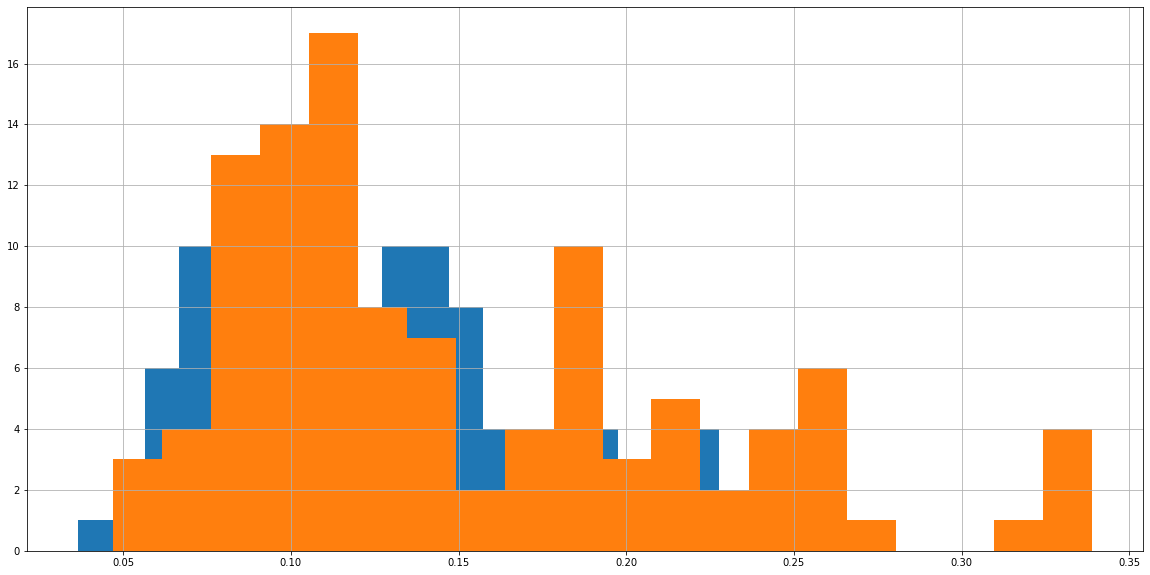

In [13]:
res_df.cat_boost_mse.hist(bins=20)
res_df.prophet_mse.hist(bins=20)

In [19]:
(res_df.prophet_mse > res_df.cat_boost_mse).mean()

0.6666666666666666

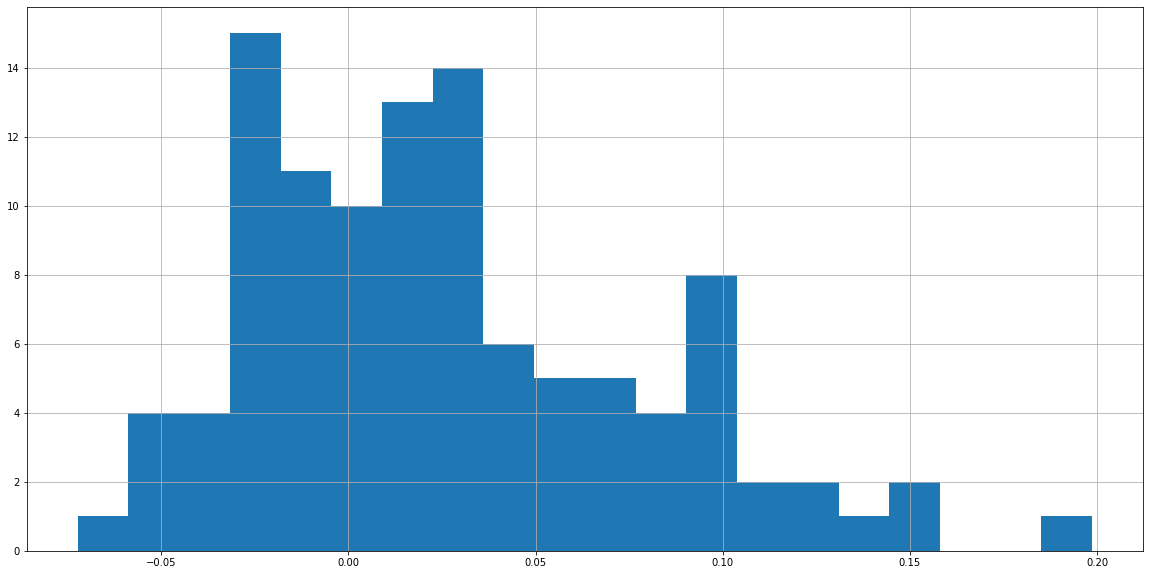

In [20]:
(res_df.prophet_mse - res_df.cat_boost_mse).hist(bins=20)